In [13]:
import music21
import os
import numpy as np
import pandas as pd
from music21 import converter, instrument, note, chord, tempo
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D, Dense, GlobalAveragePooling1D, Input, Add, Softmax
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Lambda,RepeatVector,TimeDistributed,Layer,Embedding, Dense, LayerNormalization, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from mido import MidiFile
import fractions
from tensorflow.keras.optimizers import RMSprop




In [14]:
#tr√≠ch xu·∫•t th√¥ng tin t·ª´ file MIDI, bao g·ªìm n·ªët nh·∫°c, nh·∫°c c·ª•, th·ªùi gian v√† l∆∞u v√†o CSV.
def read_midi_with_music21(file_path): # h√†m nh·∫≠n v√†o ƒë∆∞·ªùng d·∫´n c·ªßa file mid v√† tr√≠ch xu·∫•t th√¥ng tin v·ªÅ c√°c n·ªët nh·∫°c v√† nh·∫°c c·ª•.
    #Tr·∫£ v·ªÅ m·ªôt danh s√°ch ch·ª©a th√¥ng tin v·ªÅ c√°c n·ªët nh·∫°c c√≥ trong file mid
    """
    ƒê·ªçc v√† tr√≠ch xu·∫•t th√¥ng tin t·ª´ file MIDI s·ª≠ d·ª•ng music21.
    
    Args:
        file_path (str): ƒê∆∞·ªùng d·∫´n file MIDI.
    
    Returns:
        list: Danh s√°ch ch·ª©a th√¥ng tin v·ªÅ nh·∫°c c·ª• v√† n·ªët nh·∫°c trong b√†i h√°t.
    """
    try:
        # Load file MIDI
        midi_data = music21.converter.parse(file_path)
        
        song_data = []
        
        # Duy·ªát qua t·∫•t c·∫£ c√°c nh·∫°c c·ª• trong file MIDI
        for part in midi_data.parts: # l·∫•y t·∫•t c·∫£ c√°c ph·∫ßn nh·∫°c c·ª• c√≥ trong b·∫£n mid
            instrument = part.getInstrument()   # l·∫•y th√¥ng tin v·ªÅ nh·∫°c c·ª• c·ªßa ph·∫ßn nh·∫°c ƒë√≥
            instrument_name = str(instrument)
            # L·∫•y th√¥ng tin c√°c n·ªët nh·∫°c trong ph·∫ßn nh·∫°c c·ª•
            for note in part.flatten().notes:  # Thay .flat b·∫±ng .flatten()
                if isinstance(note, music21.note.Note):  # N·∫øu l√† n·ªët nh·∫°c
                    song_data.append({
                        "file_name": os.path.basename(file_path),# t√™n file mid
                        "note_type": "Note",
                        "pitch": note.name,# cao ƒë·ªô c·ªßa n·ªët 
                        "duration": note.quarterLength,# ƒë·ªô d√†i n·ªët
                        "start_time": note.offset,#time n·ªët b·∫Øt ƒë·∫ßu trong b√†i h√°t 
                    })
                elif isinstance(note, music21.note.Rest):  # N·∫øu l√† ngh·ªâ
                    song_data.append({
                        "file_name": os.path.basename(file_path),
                        "instrument": instrument_name,
                        "note_type": "Rest",
                        "pitch": "Rest", 
                        "duration": note.quarterLength,
                        "start_time": note.offset,
                    })
        
        return song_data
    
    except Exception as e:
        print(f"L·ªói khi ƒë·ªçc file MIDI: {e}")
        return None

def segment_midi_data(midi_data, segment_length=20.0):
    """
    Chia d·ªØ li·ªáu MIDI th√†nh c√°c ƒëo·∫°n nh·ªè theo th·ªùi gian.

    Args:
        midi_data (list): D·ªØ li·ªáu MIDI ƒë√£ tr√≠ch xu·∫•t.
        segment_length (float): ƒê·ªô d√†i m·ªói ƒëo·∫°n (gi√¢y).
    
    Returns:
        list: Danh s√°ch c√°c ƒëo·∫°n ƒë√£ ph√¢n chia.
    """
    if not midi_data:
        return []
    
    max_time = max(note["start_time"] for note in midi_data)
    segments = []
    start_time = 0.0
    
    while start_time < max_time:
        end_time = start_time + segment_length
        segment = [note for note in midi_data if start_time <= note["start_time"] < end_time]
        
        if segment:
            segments.append(segment)
        
        start_time += segment_length
    
    return segments

# ƒê∆∞·ªùng d·∫´n t·ªõi th∆∞ m·ª•c ch·ª©a c√°c file MIDI
midi_files_directory = "D:/CƒêE/data"

# L·∫•y danh s√°ch t·∫•t c·∫£ c√°c file .mid trong th∆∞ m·ª•c
midi_files = [os.path.join(midi_files_directory, f) for f in os.listdir(midi_files_directory) if f.endswith('.mid')]

# Gi·ªõi h·∫°n s·ªë file ƒë·ªçc (v√≠ d·ª•: 45 file)
midi_files = midi_files[:45]

all_segmented_data = []

# X·ª≠ l√Ω t·ª´ng file
for file in midi_files:
    song_data = read_midi_with_music21(file)
    if song_data:
        segments = segment_midi_data(song_data, segment_length=20.0)
        for i, segment in enumerate(segments):
            for note in segment:
                note["segment"] = i  # Th√™m s·ªë th·ª© t·ª± ƒëo·∫°n
            all_segmented_data.extend(segment)

# L∆∞u k·∫øt qu·∫£ v√†o file CSV n·∫øu c√≥ d·ªØ li·ªáu
if all_segmented_data:
    df = pd.DataFrame(all_segmented_data)
    output_file = "D:/CƒêE/test/midi_segmented.csv"
    df.to_csv(output_file, index=False)
    print(f"D·ªØ li·ªáu ƒë√£ ƒë∆∞·ª£c l∆∞u v√†o: {output_file}")
else:
    print("Kh√¥ng c√≥ d·ªØ li·ªáu n√†o ƒë∆∞·ª£c tr√≠ch xu·∫•t.")

D·ªØ li·ªáu ƒë√£ ƒë∆∞·ª£c l∆∞u v√†o: D:/CƒêE/test/midi_segmented.csv


In [15]:
df = pd.read_csv('D:/CƒêE/test/midi_segmented.csv')
df.sample(n=15, random_state=42)  

file_name note_type pitch duration start_time  \
17245           ƒê·ªÉ Gi√≥ Cu·ªën ƒêi.mid      Note     F      3.0       18.0   
1355          Bay ƒêi Th·∫ßm LƒÉng.mid      Note     E     0.75     1112.5   
2319         Ben Doi Hiu Quanh.mid      Note     A      1.0       38.0   
19            Bay ƒêi Th·∫ßm LƒÉng.mid      Note     F      1.5       13.5   
6434         Doa Hoa Vo Thuong.mid      Note    F#     0.25     320.75   
13103         N·ªêI V√íNG TAY L·ªöN.mid      Note     D      0.5      309.0   
15057             TUOI DA BUON.mid      Note     D      0.5      363.0   
4614   Cho m·ªôt ng∆∞·ªùi n·∫±m xu·ªëng.mid      Note     D      1/3       85.5   
11523       Nh·ªõ m√πa thu H√† N·ªôi.mid      Note     B      0.5       77.5   
5170                   C√°t b·ª•i.mid      Note     C     0.25       63.5   
5479       C√íN TU·ªîI N√ÄO CHO EM.mid      Note    E-      0.5       95.0   
10711                 M∆∞a H·ªìng.mid      Note     D      0.5      124.0   
101           Bay ƒêi Th·∫ßm LƒÉng.mid      Note     E      0.5       85.0   
14855             TUOI DA BUON.mid      Note     E      0.5      292.5   
10663                 M∆∞a H·ªìng.mid      Note     C      0.5      106.5   

       segment  
17245        0  
1355        55  
2319         1  
19           0  
6434        14  
13103       15  
15057       18  
4614         4  
11523        3  
5170         3  
5479         4  
10711        6  
101          4  
14855       14  
10663        5

In [16]:
import os
import pickle
from music21 import converter, note, chord, stream

def midi_to_matrix(midi_file):
    """ ƒê·ªçc file MIDI v√† chuy·ªÉn ƒë·ªïi n√≥ th√†nh m·ªôt ma tr·∫≠n d·∫°ng piano roll """
    try:
        # ƒê·ªçc file MIDI
        midi_data = converter.parse(midi_file)
        
        # Ki·ªÉm tra xem file MIDI c√≥ ƒë√∫ng l√† m·ªôt b·∫£n nh·∫°c kh√¥ng
        if not isinstance(midi_data, stream.Score):
            print(f"L·ªói: {midi_file} kh√¥ng ph·∫£i l√† m·ªôt ƒë·ªëi t∆∞·ª£ng music21 Score")
            return None

        # L·∫•y danh s√°ch c√°c n·ªët nh·∫°c v√† h·ª£p √¢m
        piano_roll = midi_data.flat.notes
        matrix = []

        for element in piano_roll:
            if isinstance(element, note.Note):  # N·∫øu l√† n·ªët nh·∫°c ƒë∆°n
                matrix.append({
                    "pitch": element.nameWithOctave,  # Cao ƒë·ªô c·ªßa n·ªët
                    "duration": element.quarterLength,  # ƒê·ªô d√†i n·ªët (theo ƒë∆°n v·ªã n·ªët ƒëen)
                    "offset": element.offset,  # V·ªã tr√≠ b·∫Øt ƒë·∫ßu c·ªßa n·ªët nh·∫°c
                    "velocity": element.volume.velocity if element.volume else None  # C∆∞·ªùng ƒë·ªô (n·∫øu c√≥)
                })
            elif isinstance(element, chord.Chord):  # N·∫øu l√† h·ª£p √¢m
                for pitch in element.pitches:
                    matrix.append({
                        "pitch": pitch.nameWithOctave,  
                        "duration": element.quarterLength,  
                        "offset": element.offset,  
                        "velocity": element.volume.velocity if element.volume else None
                    })
        
        return matrix
    except Exception as e:
        print(f"L·ªói khi ƒë·ªçc file MIDI {midi_file}: {e}")
        return None

# ƒê∆∞·ªùng d·∫´n t·ªõi th∆∞ m·ª•c ch·ª©a c√°c file MIDI
midi_files_directory = r"D:\CƒêE\data"  # Th√™m 'r' ƒë·ªÉ tr√°nh l·ªói escape sequence

# Ki·ªÉm tra th∆∞ m·ª•c c√≥ t·ªìn t·∫°i kh√¥ng
if not os.path.exists(midi_files_directory):
    raise FileNotFoundError(f"Th∆∞ m·ª•c {midi_files_directory} kh√¥ng t·ªìn t·∫°i!")

# L·∫•y danh s√°ch file MIDI
midi_files = [os.path.join(midi_files_directory, f) for f in os.listdir(midi_files_directory) if f.endswith('.mid')]

# Gi·ªõi h·∫°n s·ªë l∆∞·ª£ng file ƒë·ªçc l√† 41
midi_files = midi_files[:41]

# X·ª≠ l√Ω v√† l∆∞u d·ªØ li·ªáu
processed_data = []

for file in midi_files:
    print(f"Processing: {file}")
    matrix = midi_to_matrix(file)
    if matrix:
        processed_data.append(matrix)

# L∆∞u d·ªØ li·ªáu ƒë√£ x·ª≠ l√Ω v√†o file pickle
output_file = r"D:\CƒêE\test\midi_data_music21.pkl"
with open(output_file, "wb") as f:
    pickle.dump(processed_data, f)

print(f"L∆∞u d·ªØ li·ªáu ho√†n t·∫•t! File l∆∞u t·∫°i {output_file}")


Processing: D:\CƒêE\data\Bay ƒêi Th·∫ßm LƒÉng.mid

d:\CƒêE\myenv\Lib\site-packages\music21\stream\base.py:3689: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


Processing: D:\CƒêE\data\Ben Doi Hiu Quanh.mid
Processing: D:\CƒêE\data\Bi·ªÉn nh·ªõ.mid
Processing: D:\CƒêE\data\Ca Dao M·∫π.mid
Processing: D:\CƒêE\data\Chi·∫øc l√° tu pai.mid
Processing: D:\CƒêE\data\Cho m·ªôt ng∆∞·ªùi n·∫±m xu·ªëng.mid
Processing: D:\CƒêE\data\Cho ƒê·ªùi Ch√∫t ∆†n.mid
Processing: D:\CƒêE\data\Co Xot Xa Dua.mid
Processing: D:\CƒêE\data\Cu·ªëi C√πng Cho M·ªôt T√¨nh Y√™u.mid
Processing: D:\CƒêE\data\C√°t b·ª•i.mid
Processing: D:\CƒêE\data\C√íN TU·ªîI N√ÄO CHO EM.mid
Processing: D:\CƒêE\data\C√≥ m·ªôt d√≤ng s√¥ng ƒë√£ qua ƒë·ªùi..mid
Processing: D:\CƒêE\data\Di·ªÖm x∆∞a.mid
Processing: D:\CƒêE\data\Doa Hoa Vo Thuong.mid
Processing: D:\CƒêE\data\Em C√≤n Nh·ªõ Hay Em ƒê√£ Qu√™n.mid
Processing: D:\CƒêE\data\Em H√£y Ng·ªß ƒêi.mid
Processing: D:\CƒêE\data\Gia t√†i c·ªßa M·∫π.mid
Processing: D:\CƒêE\data\Goi Ten Bon Mua.mid
Processing: D:\CƒêE\data\Hay yeu nhau di.mid
Processing: D:\CƒêE\data\Hoa v√†ng m·∫•y ƒë·ªô..mid
Processing: D:\CƒêE\data\Hue Sai Gon Ha Noi.mid
Processi

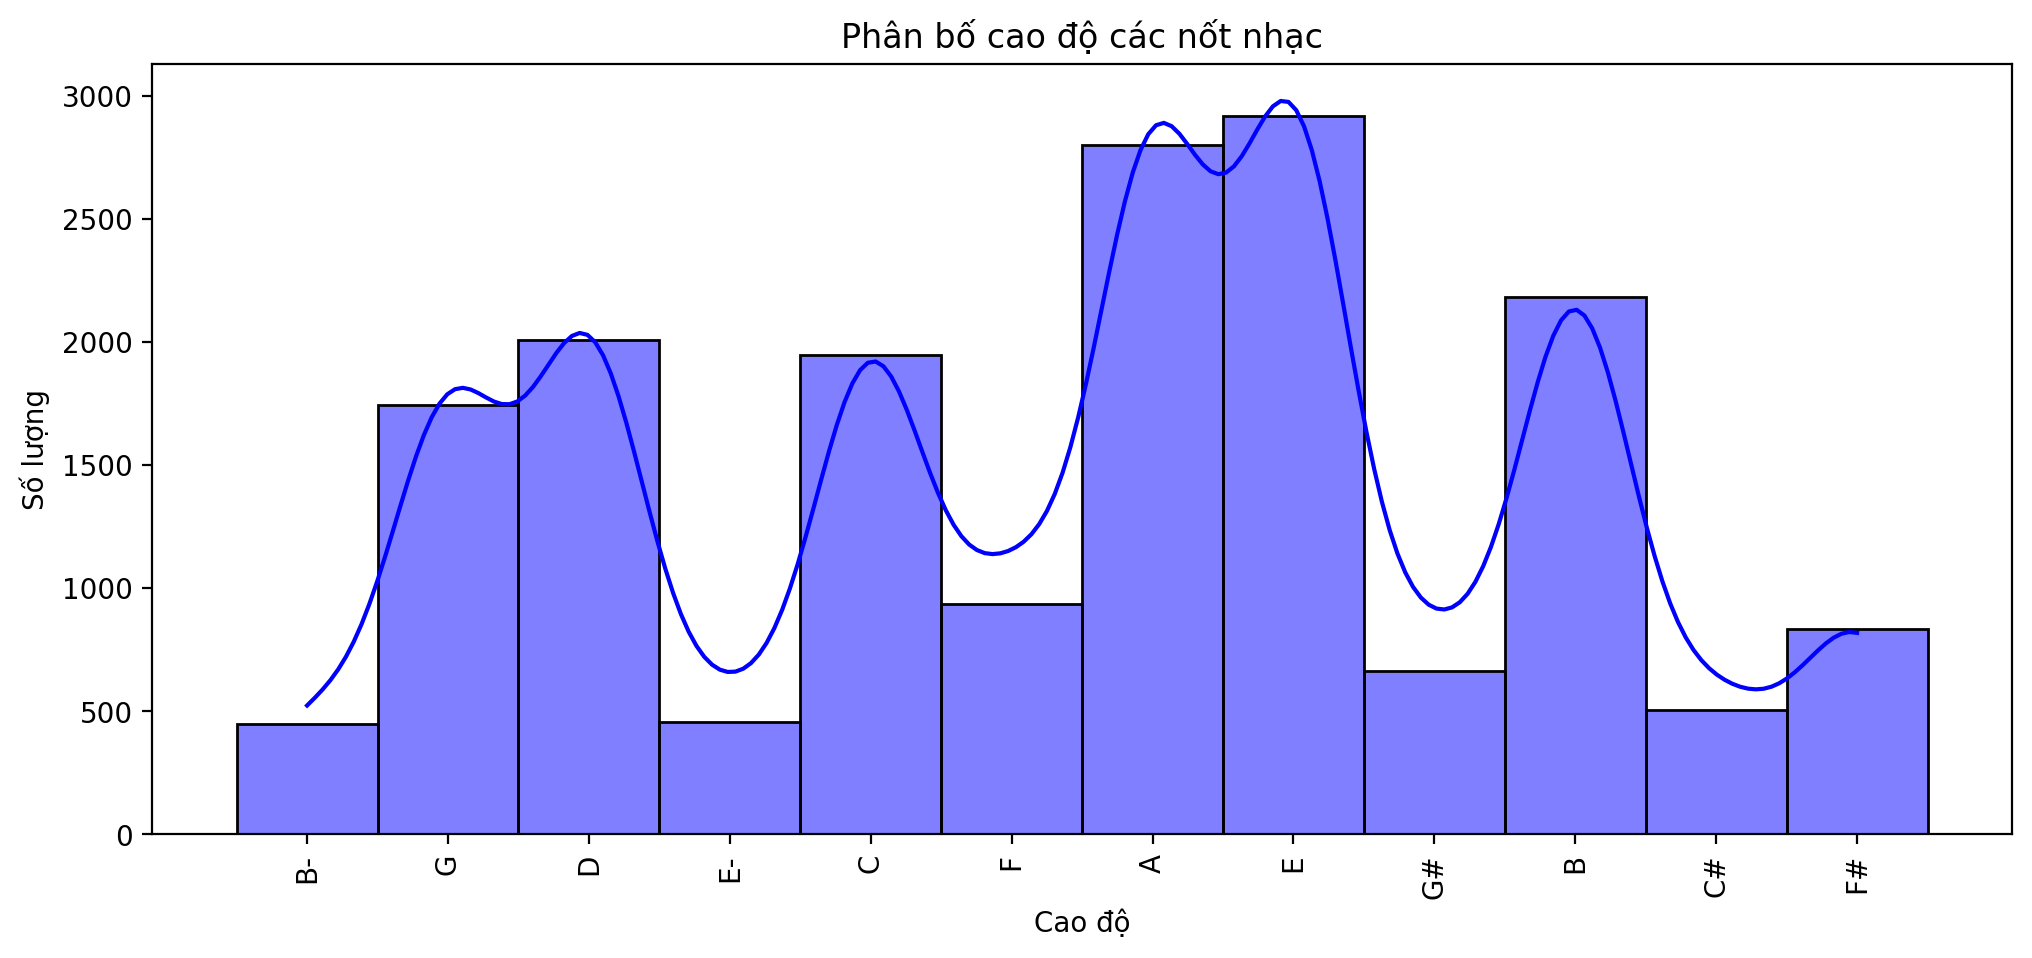

In [5]:
# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(12, 5))
sns.histplot(df['pitch'], bins=30, kde=True, color='blue')
plt.title("Ph√¢n b·ªë cao ƒë·ªô c√°c n·ªët nh·∫°c")
plt.xlabel("Cao ƒë·ªô")
plt.ylabel("S·ªë l∆∞·ª£ng")
plt.xticks(rotation=90)
plt.show()


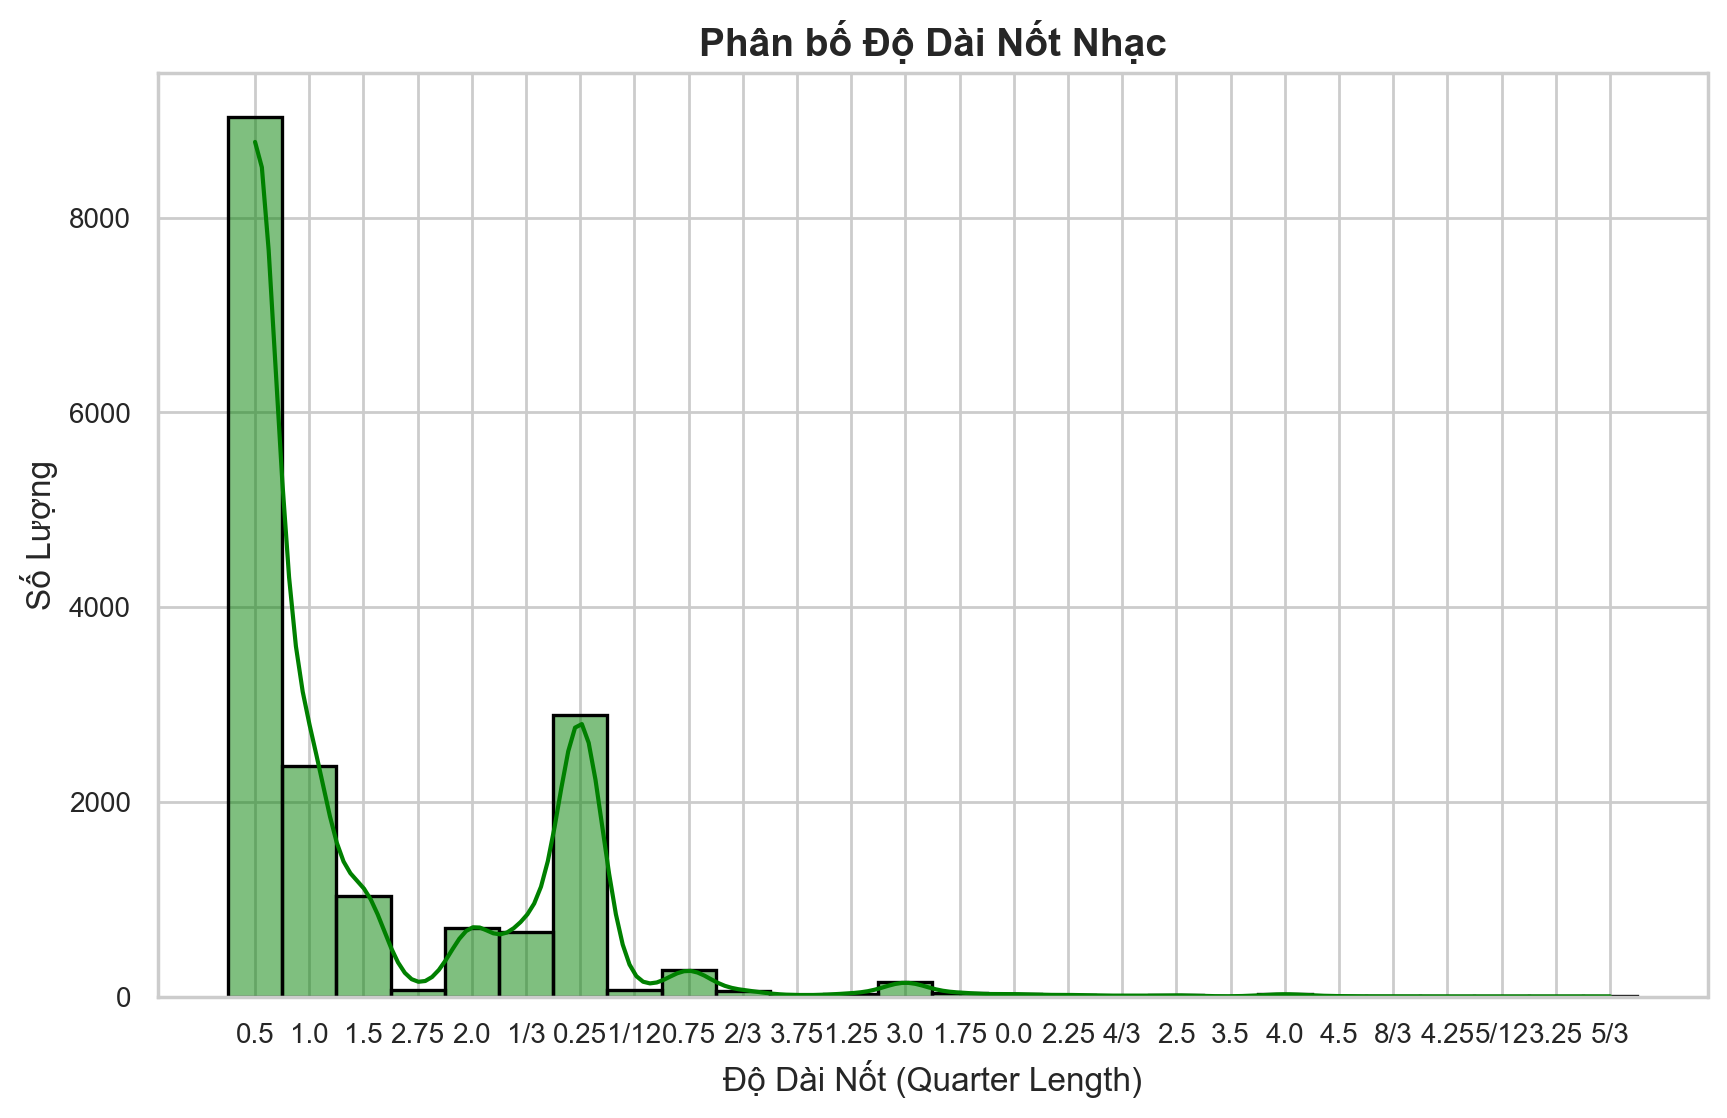

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Thi·∫øt l·∫≠p phong c√°ch
sns.set_theme(style="whitegrid")

# V·∫Ω bi·ªÉu ƒë·ªì ph√¢n b·ªë ƒë·ªô d√†i n·ªët nh·∫°c
plt.figure(figsize=(10, 6))
sns.histplot(df['duration'], bins=20, kde=True, color='green', edgecolor='black', linewidth=1.2)

# T√πy ch·ªânh nh√£n v√† ti√™u ƒë·ªÅ
plt.title("Ph√¢n b·ªë ƒê·ªô D√†i N·ªët Nh·∫°c", fontsize=14, fontweight='bold')
plt.xlabel("ƒê·ªô D√†i N·ªët (Quarter Length)", fontsize=12)
plt.ylabel("S·ªë L∆∞·ª£ng", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Hi·ªÉn th·ªã bi·ªÉu ƒë·ªì
plt.show()


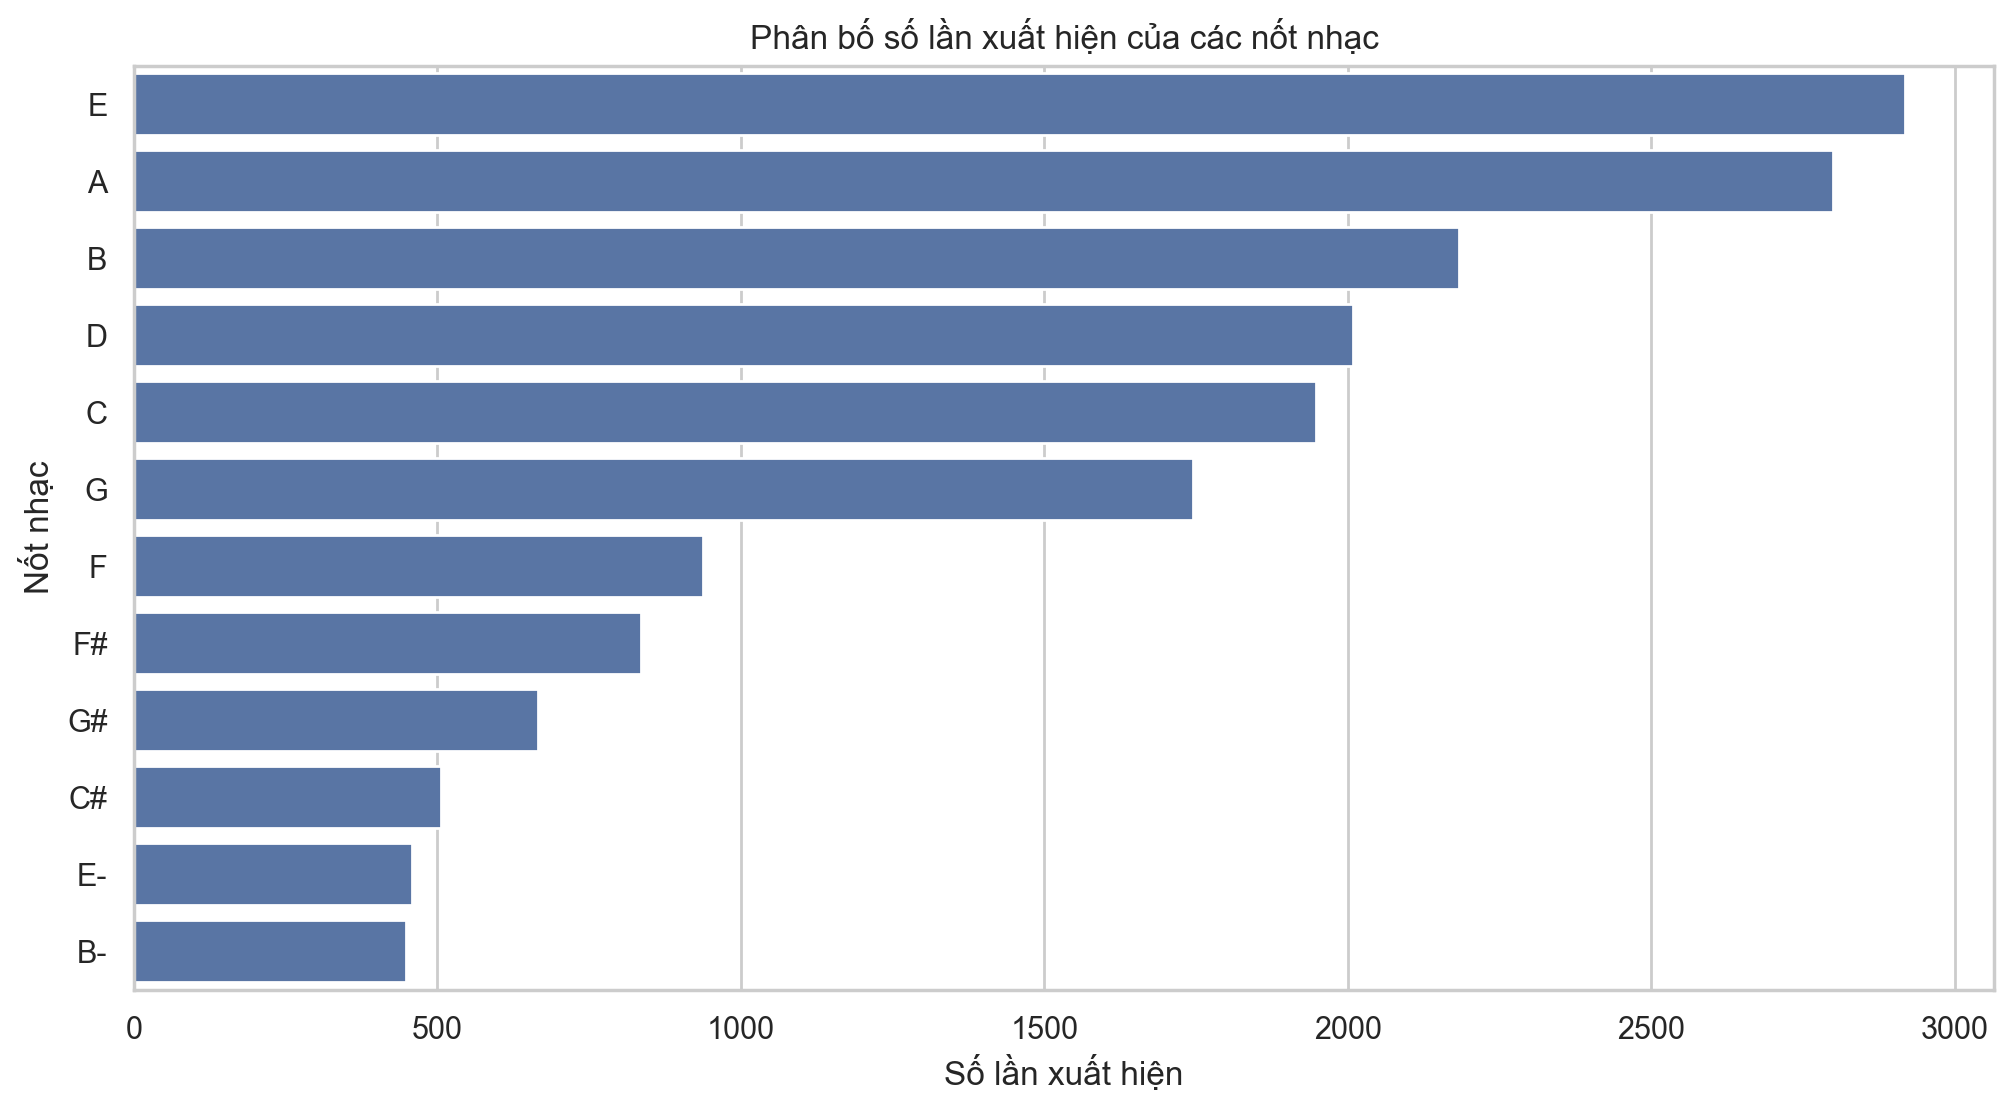

In [7]:
# **1. Ph√¢n b·ªë cao ƒë·ªô c·ªßa n·ªët nh·∫°c**
plt.figure(figsize=(12, 6))
sns.countplot(y=df["pitch"], order=df["pitch"].value_counts().index)
plt.xlabel("S·ªë l·∫ßn xu·∫•t hi·ªán")
plt.ylabel("N·ªët nh·∫°c")
plt.title("Ph√¢n b·ªë s·ªë l·∫ßn xu·∫•t hi·ªán c·ªßa c√°c n·ªët nh·∫°c")
plt.show()

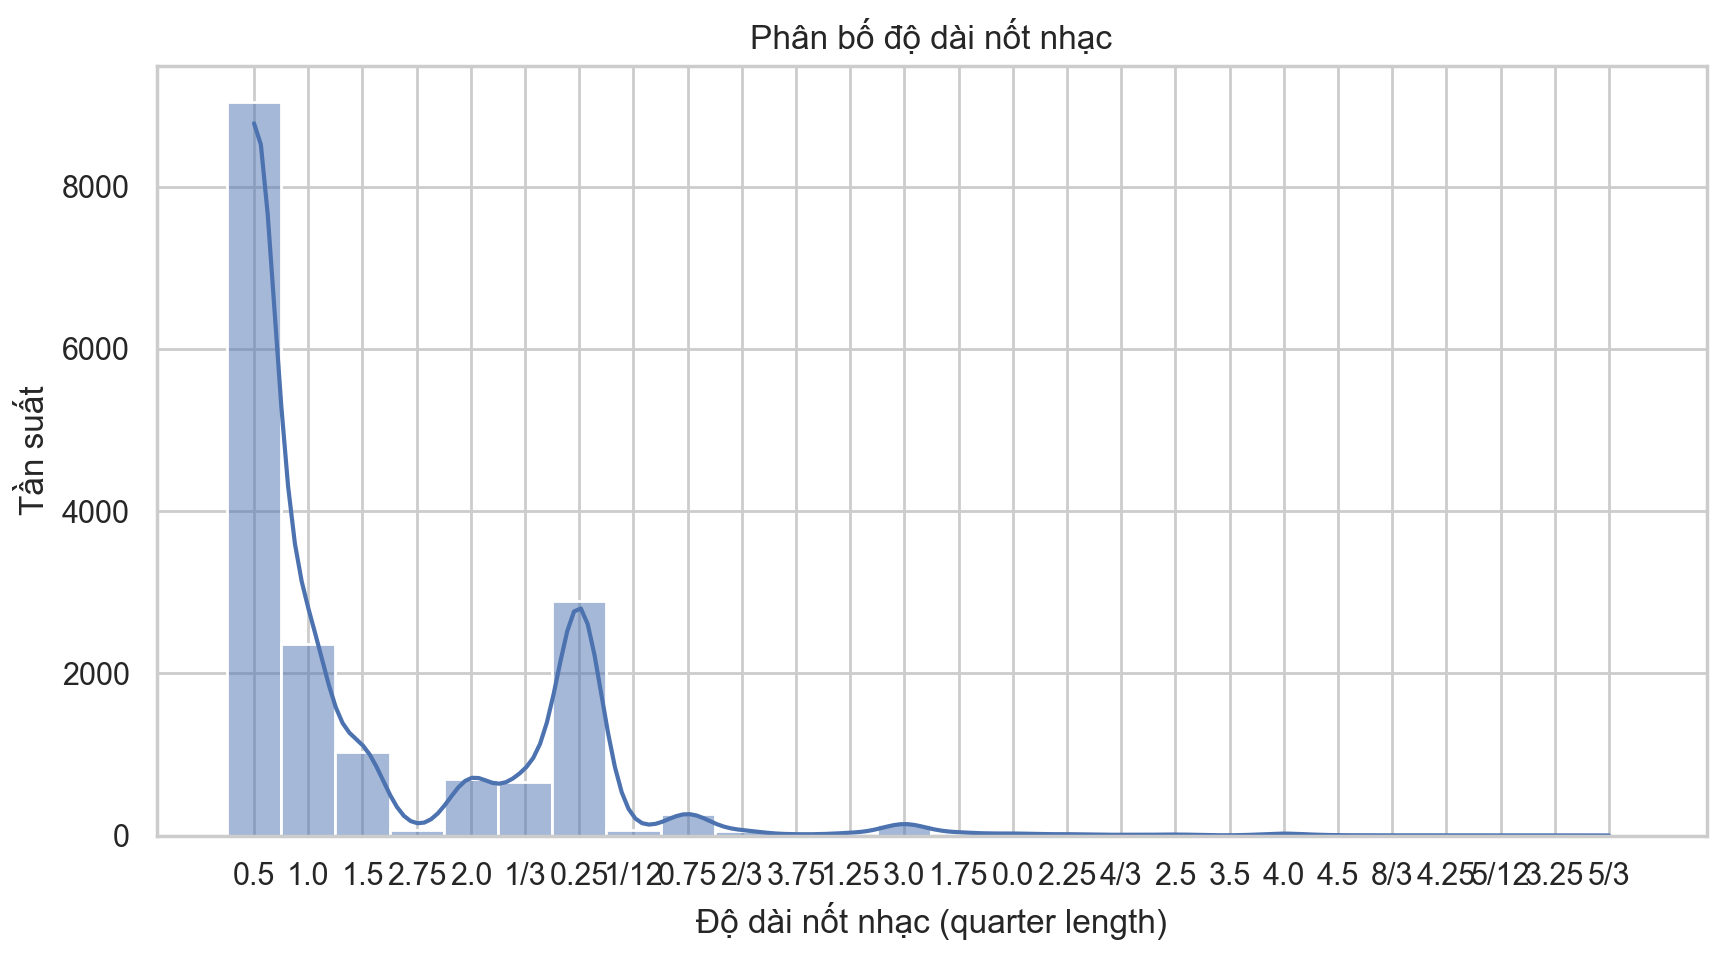

In [8]:
# **2. Ph√¢n b·ªë ƒë·ªô d√†i c·ªßa n·ªët nh·∫°c**
plt.figure(figsize=(10, 5))
sns.histplot(df["duration"], bins=30, kde=True)
plt.xlabel("ƒê·ªô d√†i n·ªët nh·∫°c (quarter length)")
plt.ylabel("T·∫ßn su·∫•t")
plt.title("Ph√¢n b·ªë ƒë·ªô d√†i n·ªët nh·∫°c")
plt.show()

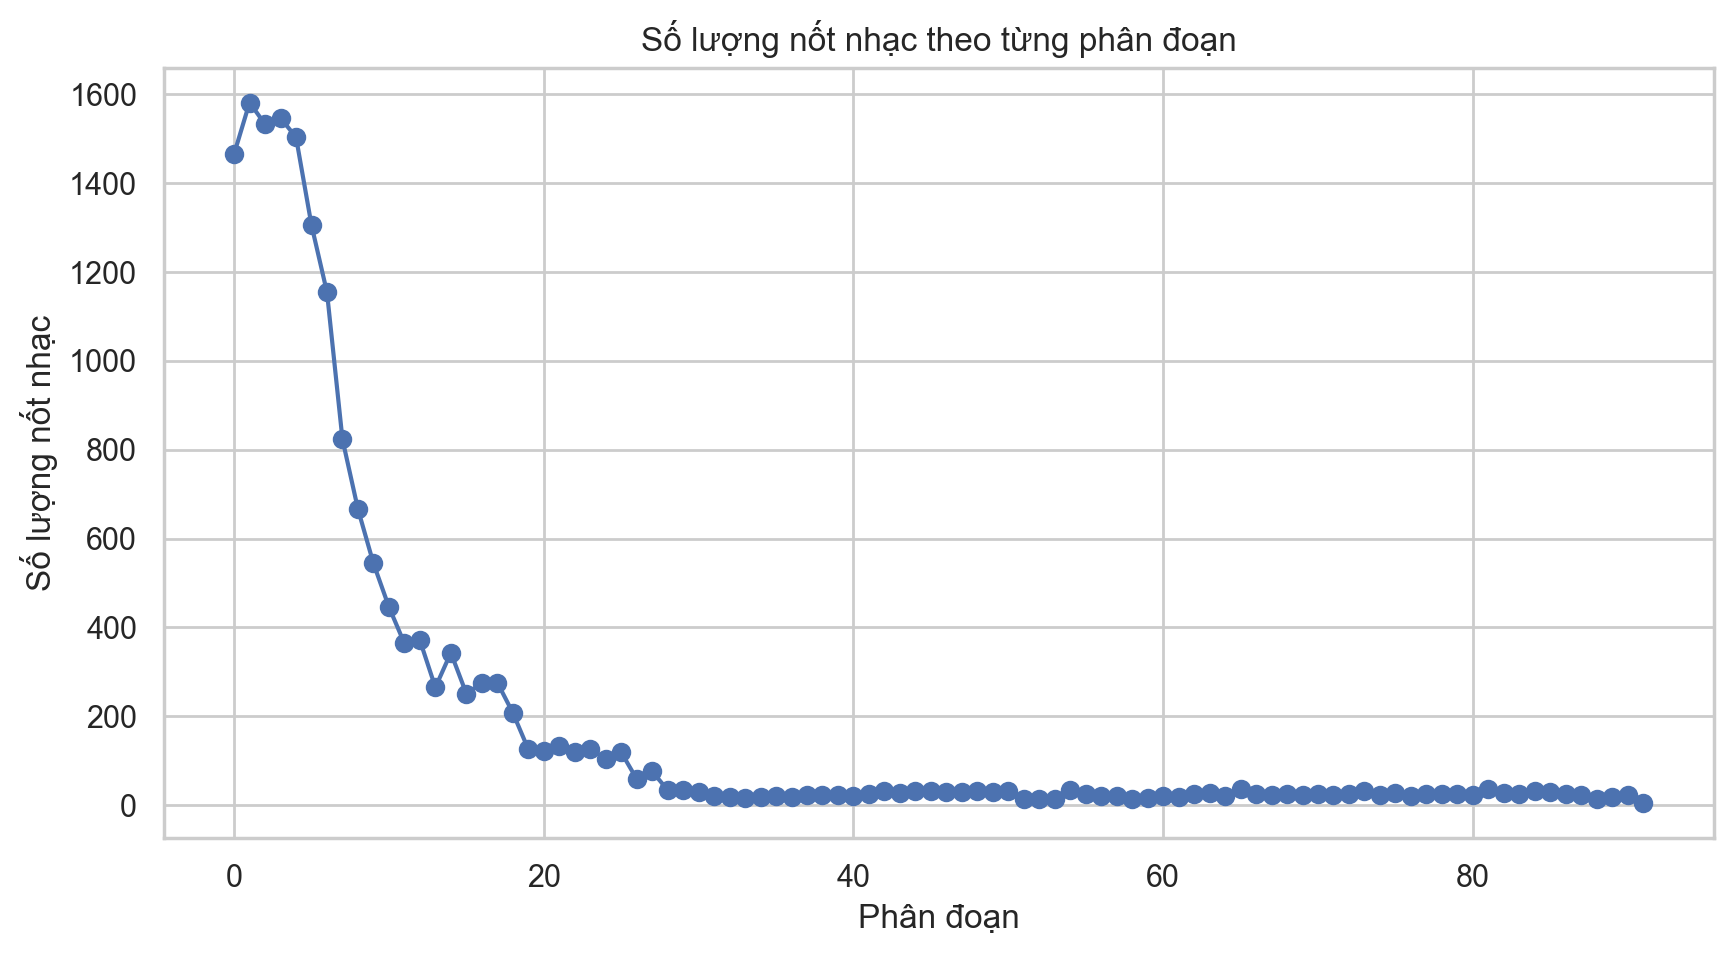

In [9]:
# **4. S·ªë l∆∞·ª£ng n·ªët nh·∫°c theo ph√¢n ƒëo·∫°n**
plt.figure(figsize=(10, 5))
df_segment_count = df.groupby("segment").size()
plt.plot(df_segment_count.index, df_segment_count.values, marker="o", linestyle="-")
plt.xlabel("Ph√¢n ƒëo·∫°n")
plt.ylabel("S·ªë l∆∞·ª£ng n·ªët nh·∫°c")
plt.title("S·ªë l∆∞·ª£ng n·ªët nh·∫°c theo t·ª´ng ph√¢n ƒëo·∫°n")
plt.grid(True)
plt.show()

m√¥ h√¨nh LSMT

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Load d·ªØ li·ªáu t·ª´ file pickle
with open("D:/CƒêE/test/midi_data_music21.pkl", "rb") as f:
    loaded_data = pickle.load(f)

# Ki·ªÉm tra lo·∫°i d·ªØ li·ªáu
print(f"Ki·ªÉu d·ªØ li·ªáu c·ªßa loaded_data: {type(loaded_data)}")

# N·∫øu d·ªØ li·ªáu l√† danh s√°ch, ta c·∫ßn chuy·ªÉn ƒë·ªïi ƒë√∫ng ƒë·ªãnh d·∫°ng
if isinstance(loaded_data, dict):  
    midi_data = loaded_data["data"]
    note_to_int = loaded_data["note_to_int"]
elif isinstance(loaded_data, list):  
    midi_data = loaded_data  # N·∫øu file ch·ªâ ch·ª©a danh s√°ch d·ªØ li·ªáu MIDI
    # T·∫°o mapping note_to_int
    all_notes = sorted(set(note["pitch"] for song in midi_data for note in song))
    note_to_int = {note: i + 1 for i, note in enumerate(all_notes)}
else:
    raise ValueError("L·ªói: D·ªØ li·ªáu trong file pickle kh√¥ng ƒë√∫ng ƒë·ªãnh d·∫°ng!")

num_notes = len(note_to_int) + 1  # Th√™m 1 ƒë·ªÉ tr√°nh l·ªói khi mapping

# Chuy·ªÉn ƒë·ªïi d·ªØ li·ªáu MIDI th√†nh chu·ªói hu·∫•n luy·ªán
X, y = [], []
seq_length = 100  # ƒê·ªô d√†i m·ªói chu·ªói hu·∫•n luy·ªán

for song in midi_data:
    notes = np.array([note_to_int.get(note["pitch"], 0) for note in song])  # M·∫∑c ƒë·ªãnh 0 n·∫øu kh√¥ng c√≥ trong mapping

    for i in range(len(notes) - seq_length):
        X.append(notes[i:i + seq_length])
        y.append(notes[i + seq_length])  # N·ªët ti·∫øp theo

X = np.array(X).reshape(len(X), seq_length, 1)  # Th√™m chi·ªÅu th·ª© 2 cho ph√π h·ª£p v·ªõi LSTM
y = np.array(y)
# chia t·∫≠p d·ªØ li·ªáu
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")
# X√¢y d·ª±ng m√¥ h√¨nh LSTM
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(256, return_sequences=False),
    Dense(num_notes, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam",metrics=["accuracy"])

# Hu·∫•n luy·ªán m√¥ h√¨nh
history_lstm= model.fit(X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32)

# L∆∞u m√¥ h√¨nh
model.save("D:/CƒêE/test/music_generator_lstm.h5")

print("Hu·∫•n luy·ªán ho√†n t·∫•t v√† m√¥ h√¨nh ƒë√£ ƒë∆∞·ª£c l∆∞u!")

Ki·ªÉu d·ªØ li·ªáu c·ªßa loaded_data: <class 'list'>
Train: (17305, 100, 1), Validation: (3708, 100, 1), Test: (3709, 100, 1)


d:\CƒêE\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
541/541 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 258s 469ms/step - accuracy: 0.0730 - loss: 3.6419 - val_accuracy: 0.0930 - val_loss: 3.4721
Epoch 2/50
541/541 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 267s 478ms/step - accuracy: 0.1100 - loss: 3.4148 - val_accuracy: 0.1303 - val_loss: 3.2743
Epoch 3/50
541/541 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 232s 429ms/step - accuracy: 0.1452 - loss: 3.2090 - val_accuracy: 0.1683 - val_loss: 3.0903
Epoch 4/50
541/541 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 205s 378ms/step - accuracy: 0.1923 - loss: 2.9791 - val_accuracy: 0.1958 - val_loss: 2.9498
Epoch 5/50
541/541 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 209s 385ms/step - accuracy: 0.2349 - loss: 2.7725 - val_accuracy: 0.2109 - val_loss: 2.8738
Epoch 6/50
541/541 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 209s 386ms/step - accuracy: 0.2781 - loss: 2.5937 - val_accu

Hu·∫•n luy·ªán ho√†n t·∫•t v√† m√¥ h√¨nh ƒë√£ ƒë∆∞·ª£c l∆∞u!


In [ ]:

import random
# Load m√¥ h√¨nh ƒë√£ hu·∫•n luy·ªán
model = load_model("D:/CƒêE/test/music_generator_lstm.h5")

# Kh·ªüi t·∫°o seed ƒë·ªÉ sinh nh·∫°c
start_index = random.randint(0, len(X_train) - 1)
seed_sequence = X_train[start_index]

generated_notes = []
num_generate = 100  # S·ªë l∆∞·ª£ng n·ªët mu·ªën sinh ra

# Sinh nh·∫°c
for _ in range(num_generate):
    prediction_input = seed_sequence.reshape(1, seq_length, 1)
    predicted_index = np.argmax(model.predict(prediction_input, verbose=0))
    
    # L∆∞u l·∫°i n·ªët ƒë∆∞·ª£c sinh
    generated_notes.append(predicted_index)
    
    # C·∫≠p nh·∫≠t seed_sequence ƒë√∫ng shape
    next_note = np.array([[predicted_index]])  # (1,1)
    seed_sequence = np.vstack((seed_sequence[1:], next_note))  # (seq_length,1)

# ƒê·∫£o ng∆∞·ª£c l·∫°i t·ª´ ch·ªâ s·ªë sang t√™n n·ªët
int_to_note = {i: note for note, i in note_to_int.items()}

# T·∫°o stream nh·∫°c
output_notes = []
start_time = 0.0
duration = 0.5  # Gi·∫£ ƒë·ªãnh ƒë·ªô d√†i n·ªët c·ªë ƒë·ªãnh, b·∫°n c√≥ th·ªÉ random nh·ªè ƒë·ªÉ ƒëa d·∫°ng h∆°n

for index in generated_notes:
    pitch = int_to_note.get(index, None)
    if pitch and pitch != "Rest":
        new_note = note.Note(pitch)
        new_note.offset = start_time
        new_note.quarterLength = duration
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    start_time += duration

# T·∫°o m·ªôt b·∫£n nh·∫°c MIDI m·ªõi
midi_stream = stream.Stream(output_notes)
midi_stream.write("midi", fp="D:/CƒêE/test/generated_music_lstm.mid")
print("ƒê√£ sinh ra file MIDI")



ƒê√£ sinh ra file MIDI


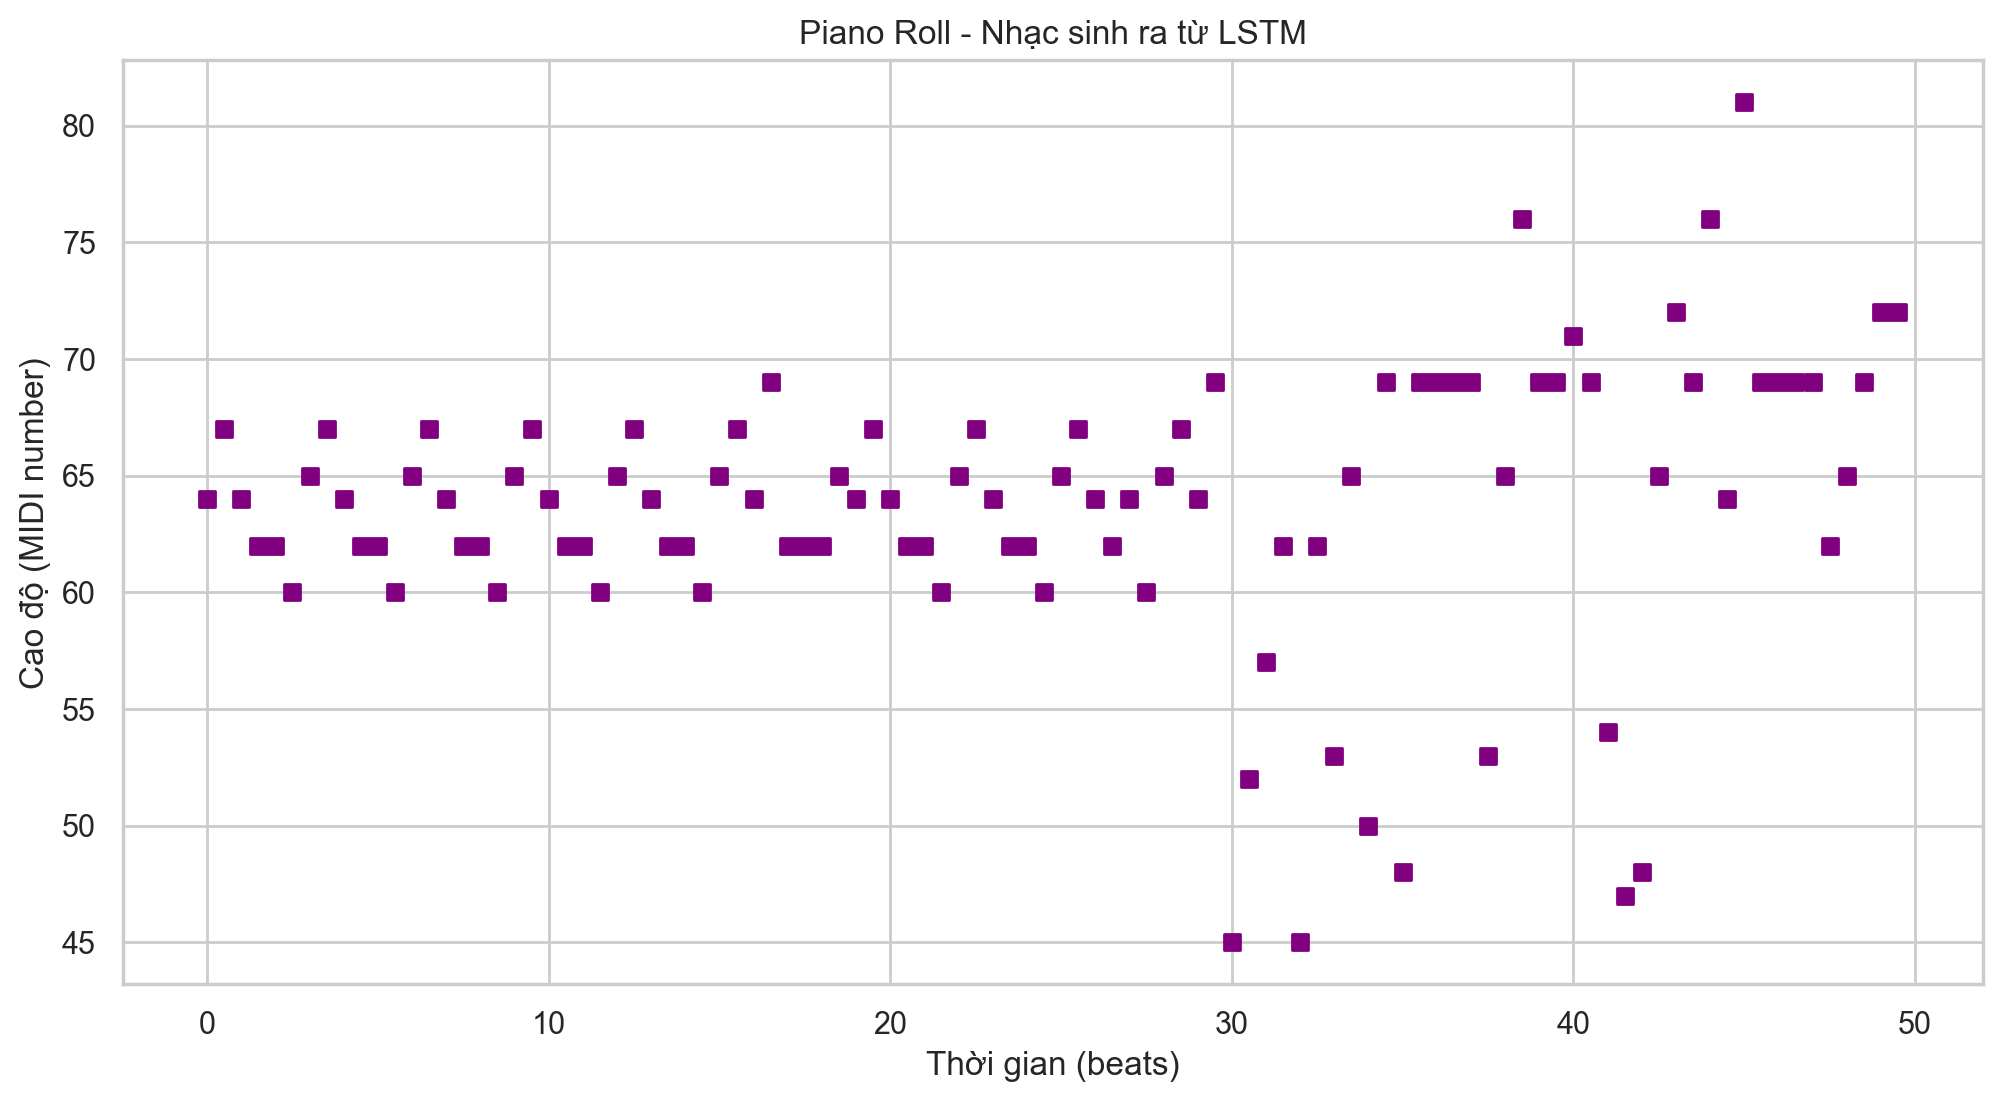

In [17]:
# Chu·∫©n b·ªã d·ªØ li·ªáu piano roll
pitches = []
times = []

for n in output_notes:
    pitches.append(n.pitch.midi)
    times.append(n.offset)

plt.figure(figsize=(12, 6))
plt.scatter(times, pitches, marker="s", color="purple")
plt.xlabel("Th·ªùi gian (beats)")
plt.ylabel("Cao ƒë·ªô (MIDI number)")
plt.title("Piano Roll - Nh·∫°c sinh ra t·ª´ LSTM")
plt.grid(True)
plt.show()


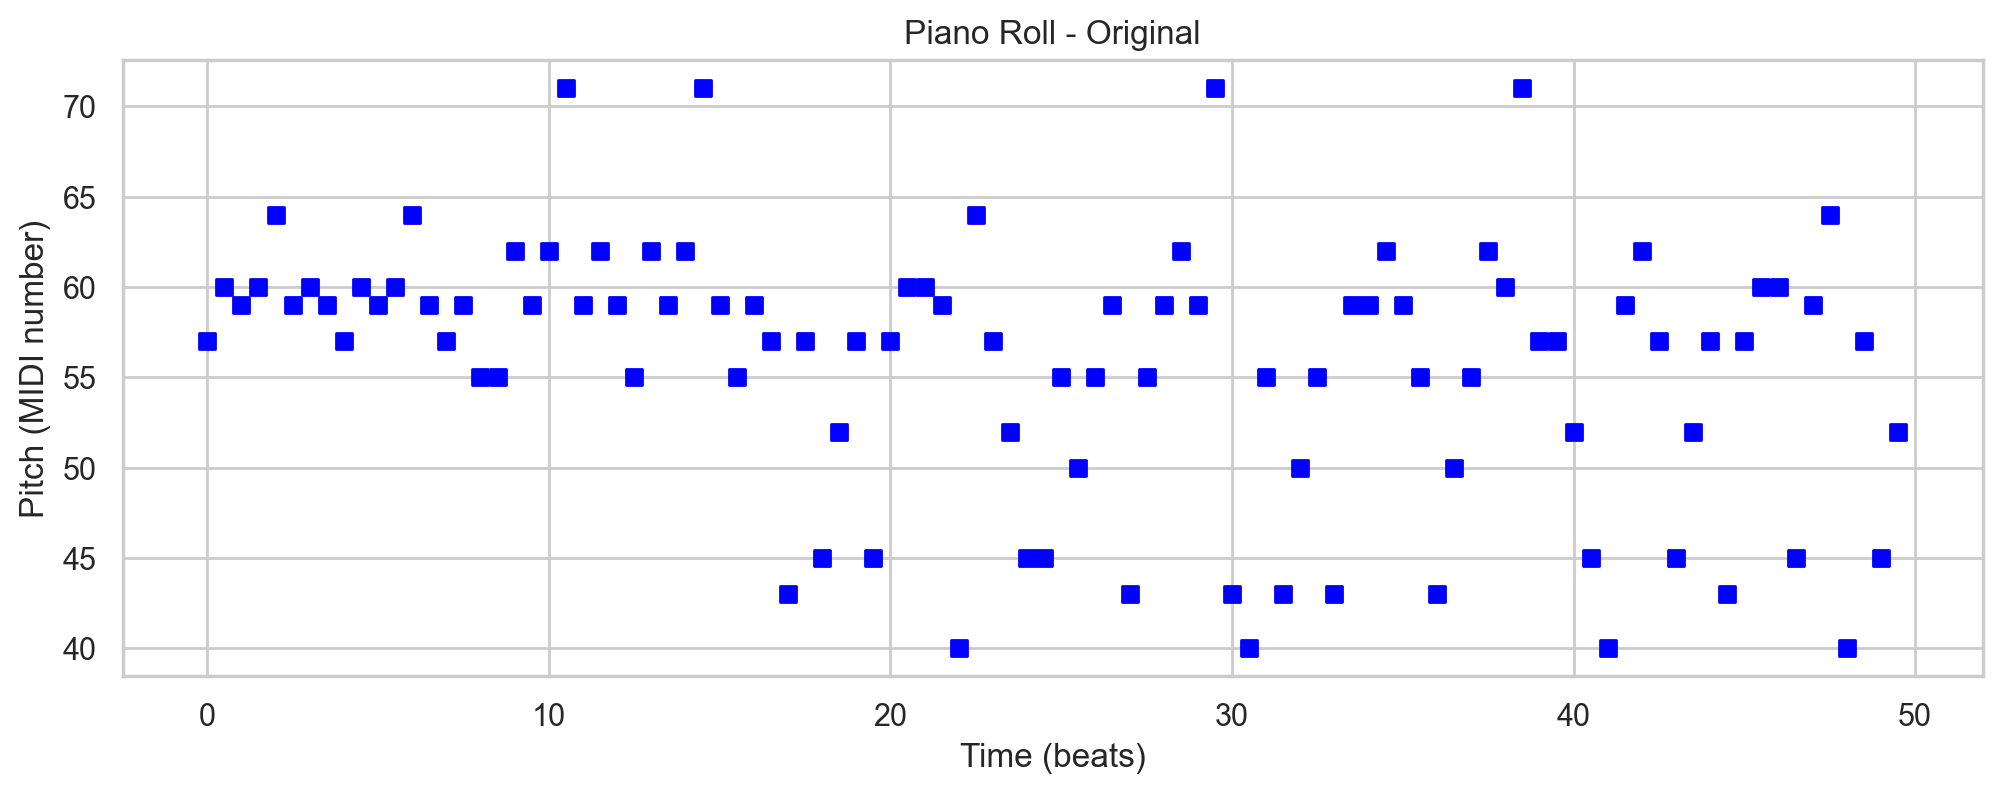

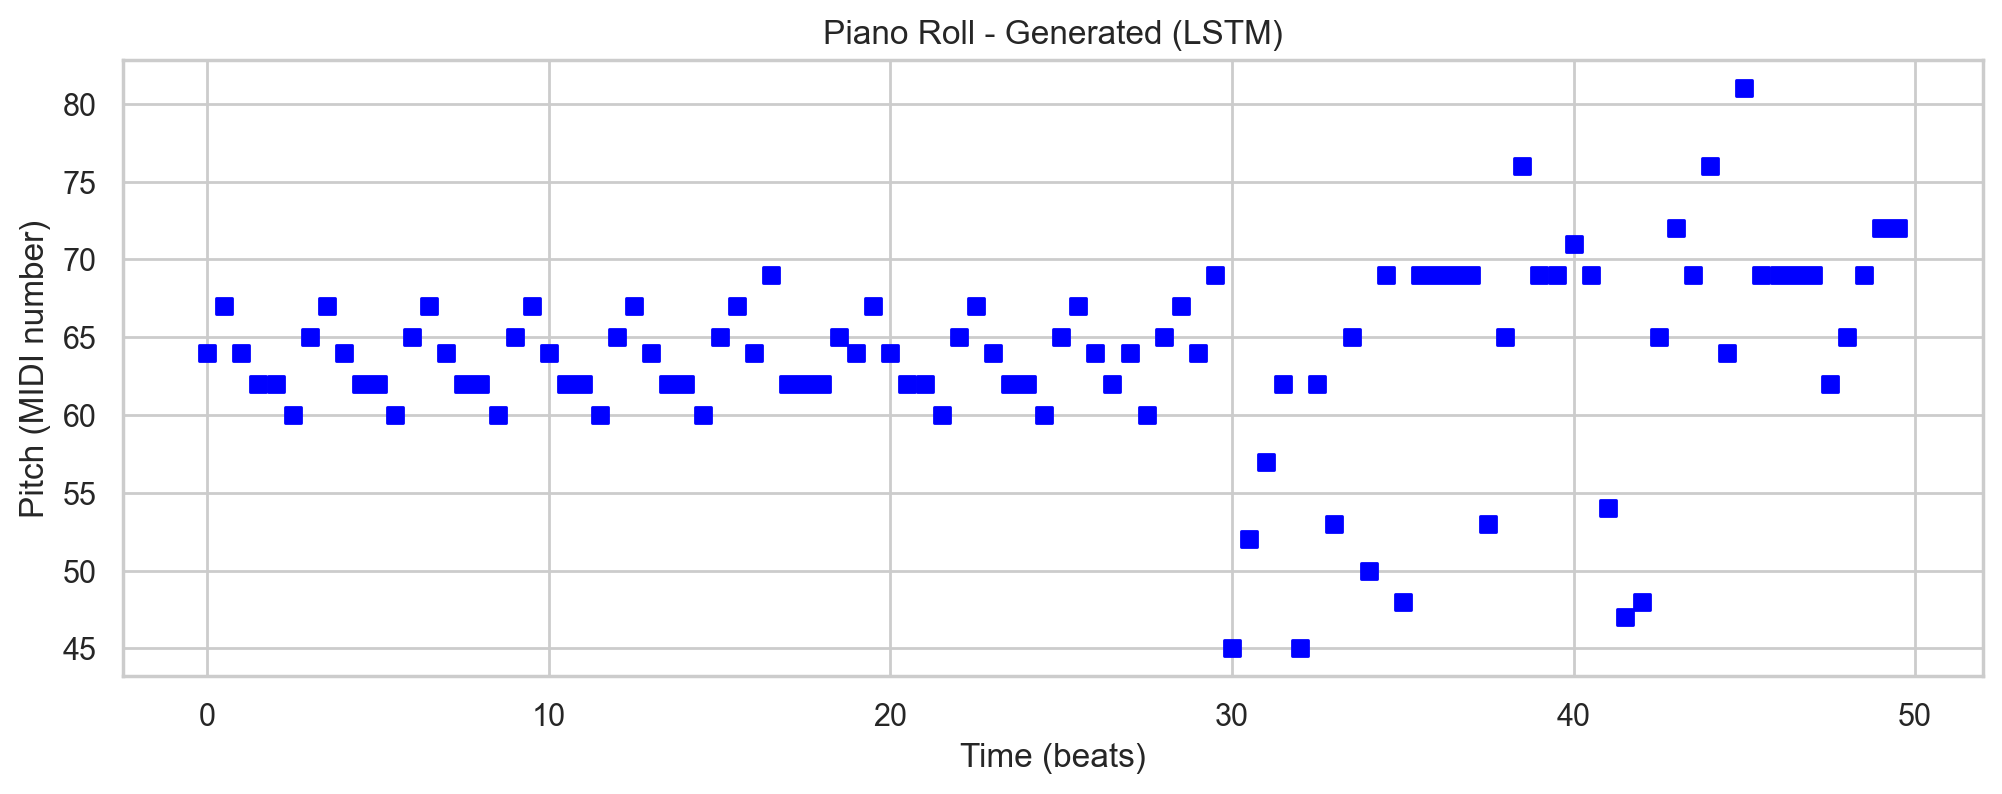

In [20]:
import matplotlib.pyplot as plt

def plot_piano_roll(note_sequence, title="Piano Roll", duration_per_note=0.5):
    """
    V·∫Ω bi·ªÉu ƒë·ªì piano roll ƒë∆°n gi·∫£n cho danh s√°ch pitch (chu·ªói n·ªët).
    note_sequence: danh s√°ch pitch (d∆∞·ªõi d·∫°ng string, v√≠ d·ª• "C4", "D#4", ...)
    """
    # Chuy·ªÉn pitch string th√†nh MIDI number ƒë·ªÉ d·ªÖ v·∫Ω (n·ªët cao h∆°n s·ªë l·ªõn h∆°n)
    pitches = []
    times = []
    for idx, pitch in enumerate(note_sequence):
        try:
            midi_number = note.Note(pitch).pitch.midi
            pitches.append(midi_number)
            times.append(idx * duration_per_note)
        except:
            continue  # B·ªè qua n·∫øu pitch kh√¥ng h·ª£p l·ªá
    
    plt.figure(figsize=(12, 4))
    plt.scatter(times, pitches, marker='s', c='blue')
    plt.xlabel("Time (beats)")
    plt.ylabel("Pitch (MIDI number)")
    plt.title(title)
    plt.grid(True)
    plt.show()
# Chu·ªói nh·∫°c g·ªëc (tr√≠ch t·ª´ b√†i ƒë·∫ßu ti√™n)
original_sequence = [note["pitch"] for note in midi_data[1][:100]]

# Chu·ªói nh·∫°c sinh ra t·ª´ m√¥ h√¨nh (ƒë√£ c√≥ ·ªü bi·∫øn generated_notes)
generated_sequence = [int_to_note[n] for n in generated_notes if n in int_to_note]

# V·∫Ω bi·ªÉu ƒë·ªì
plot_piano_roll(original_sequence, title="Piano Roll - Original")
plot_piano_roll(generated_sequence, title="Piano Roll - Generated (LSTM)")



In [21]:
# Load d·ªØ li·ªáu
with open("D:/CƒêE/test/midi_data_music21.pkl", "rb") as f:
    loaded_data = pickle.load(f)

if isinstance(loaded_data, dict):  
    midi_data = loaded_data["data"]
else:
    midi_data = loaded_data

# K·∫øt h·ª£p pitch v√† duration
all_tokens = sorted(set(f"{note['pitch']}_{note['duration']}" for song in midi_data for note in song))
token_to_int = {token: i+1 for i, token in enumerate(all_tokens)}
int_to_token = {i+1: token for token, i in token_to_int.items()}
vocab_size = len(token_to_int) + 1

# Chuy·ªÉn ƒë·ªïi th√†nh chu·ªói
seq_length = 100
X, y = [], []

for song in midi_data:
    tokens = [token_to_int[f"{note['pitch']}_{note['duration']}"] for note in song]
    for i in range(len(tokens) - seq_length):
        X.append(tokens[i:i+seq_length])
        y.append(tokens[i+seq_length])

X = np.array(X)
y = np.array(y)

# Chia t·∫≠p d·ªØ li·ªáu
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [23]:
from tensorflow.keras.layers import BatchNormalization
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=seq_length),
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),

    LSTM(256),
    Dropout(0.3),
    BatchNormalization(),

    Dense(vocab_size, activation="softmax")
])

model.build(input_shape=(None, seq_length))  # <- th√™m d√≤ng n√†y
model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

history_lstm_1= model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=64)

model.save("D:/CƒêE/test/music_generator_lstm_v2.h5")


Model: "sequential_2"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_1 (Embedding)         ‚îÇ (None, 100, 100)       ‚îÇ        64,400 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_4 (LSTM)                   ‚îÇ (None, 100, 256)       ‚îÇ       365,568 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)             ‚îÇ (None, 100, 256)       ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_2           ‚îÇ (None, 100, 256)       ‚îÇ         1,024 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_5 (LSTM)                   ‚îÇ (None, 256)            ‚îÇ       525,312 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_3 (Dropout)             ‚îÇ (None, 256)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_3           ‚îÇ (None, 256)            ‚îÇ         1,024 ‚îÇ
‚îÇ (BatchNormalization)            ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                 ‚îÇ (None, 644)            ‚îÇ       165,508 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,122,836 (4.28 MB)

 Trainable params: 1,121,812 (4.28 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/50
271/271 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 200s 713ms/step - accuracy: 0.0683 - loss: 5.5005 - val_accuracy: 0.0423 - val_loss: 5.0830
Epoch 2/50
271/271 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 193s 711ms/step - accuracy: 0.1389 - loss: 3.9913 - val_accuracy: 0.1586 - val_loss: 3.8168
Epoch 3/50
271/271 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 192s 709ms/step - accuracy: 0.2256 - loss: 3.3576 - val_accuracy: 0.2292 - val_loss: 3.3271
Epoch 4/50
271/271 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 192s 707ms/step - accuracy: 0.2906 - loss: 2.9239 - val_accuracy: 0.2802 - val_loss: 3.1191
Epoch 5/50
271/271 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 192s 708ms/step - accuracy: 0.3604 - loss: 2.5730 - val_accuracy: 0.3244 - val_loss: 2.9564
Epoch 6/50
271/271 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 201s 703ms/step - accuracy: 0.4164 - loss: 2.2770 - val_accu

In [43]:
import random

# Load m√¥ h√¨nh ƒë√£ hu·∫•n luy·ªán
model = load_model("D:/CƒêE/test/music_generator_lstm_v2.h5")

# Gi·∫£ s·ª≠ b·∫°n ƒë√£ c√≥ X_train, seq_length v√† note_to_int
# L·∫•y m·ªôt seed ng·∫´u nhi√™n t·ª´ d·ªØ li·ªáu hu·∫•n luy·ªán
start_index = random.randint(0, len(X_train) - 1)
seed_sequence = X_train[start_index]  # shape: (seq_length, 1)

# S·ªë l∆∞·ª£ng n·ªët sinh ra
num_generate = 90

# √Ånh x·∫° ng∆∞·ª£c t·ª´ ch·ªâ s·ªë v·ªÅ t√™n n·ªët
int_to_note = {i: note for note, i in note_to_int.items()}

generated_notes = []

for _ in range(num_generate):
    # reshape input v·ªÅ ƒë√∫ng ƒë·ªãnh d·∫°ng (1, seq_length, 1)
    prediction_input = seed_sequence.reshape(1, seed_sequence.shape[0], 1)

    # D·ª± ƒëo√°n n·ªët ti·∫øp theo
    predicted_index = np.argmax(model.predict(prediction_input, verbose=0))
    generated_notes.append(predicted_index)

    # C·∫≠p nh·∫≠t chu·ªói seed: b·ªè n·ªët ƒë·∫ßu, th√™m n·ªët m·ªõi
    next_note = np.array([[predicted_index]])  # shape (1, 1)
    seed_sequence = np.concatenate((seed_sequence[1:].reshape(-1, 1), next_note), axis=0)


# T·∫°o MIDI t·ª´ c√°c n·ªët ƒë√£ sinh
output_notes = []
start_time = 0.0
note_duration = 0.5  # quarterLength = 0.5 ‚Üí 1 n·ªët = 0.25 gi√¢y

for index in generated_notes:
    pitch = int_to_note.get(index, None)
    if pitch and pitch != "Rest":
        new_note = note.Note(pitch)
        new_note.offset = start_time
        new_note.quarterLength = note_duration
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    start_time += note_duration

# T·∫°o stream nh·∫°c v√† th√™m tempo
midi_stream = stream.Stream()
midi_stream.append(tempo.MetronomeMark(number=80))
for n in output_notes:
    midi_stream.append(n)

# Xu·∫•t ra file MIDI
output_path = "D:/CƒêE/test/generated_music_lstm_2.mid"
midi_stream.write("midi", fp=output_path)
print(f"ƒê√£ sinh nh·∫°c v√† l∆∞u t·∫°i: {output_path}")



ƒê√£ sinh nh·∫°c v√† l∆∞u t·∫°i: D:/CƒêE/test/generated_music_lstm_2.mid


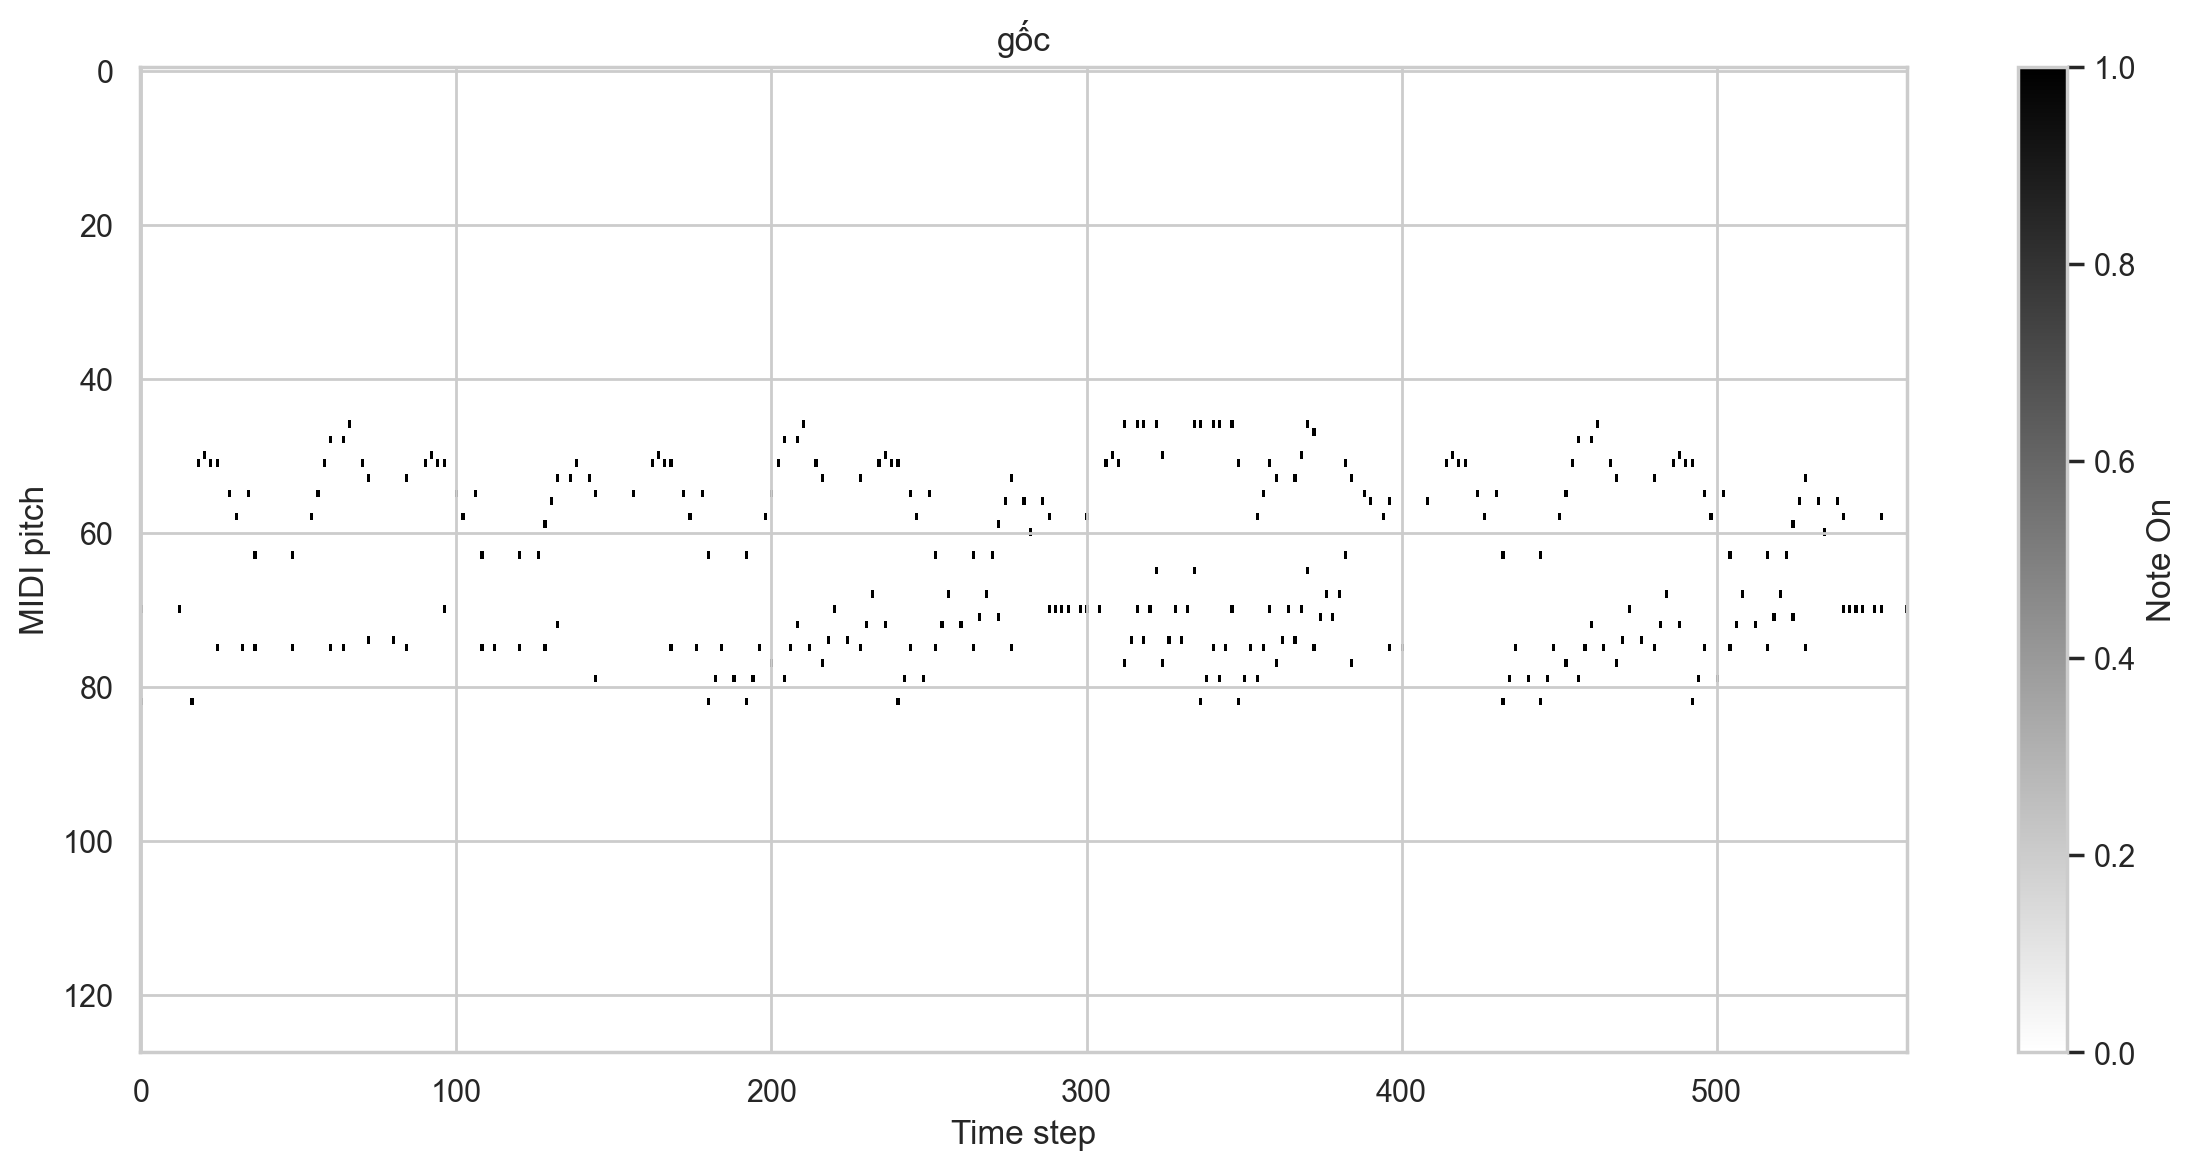

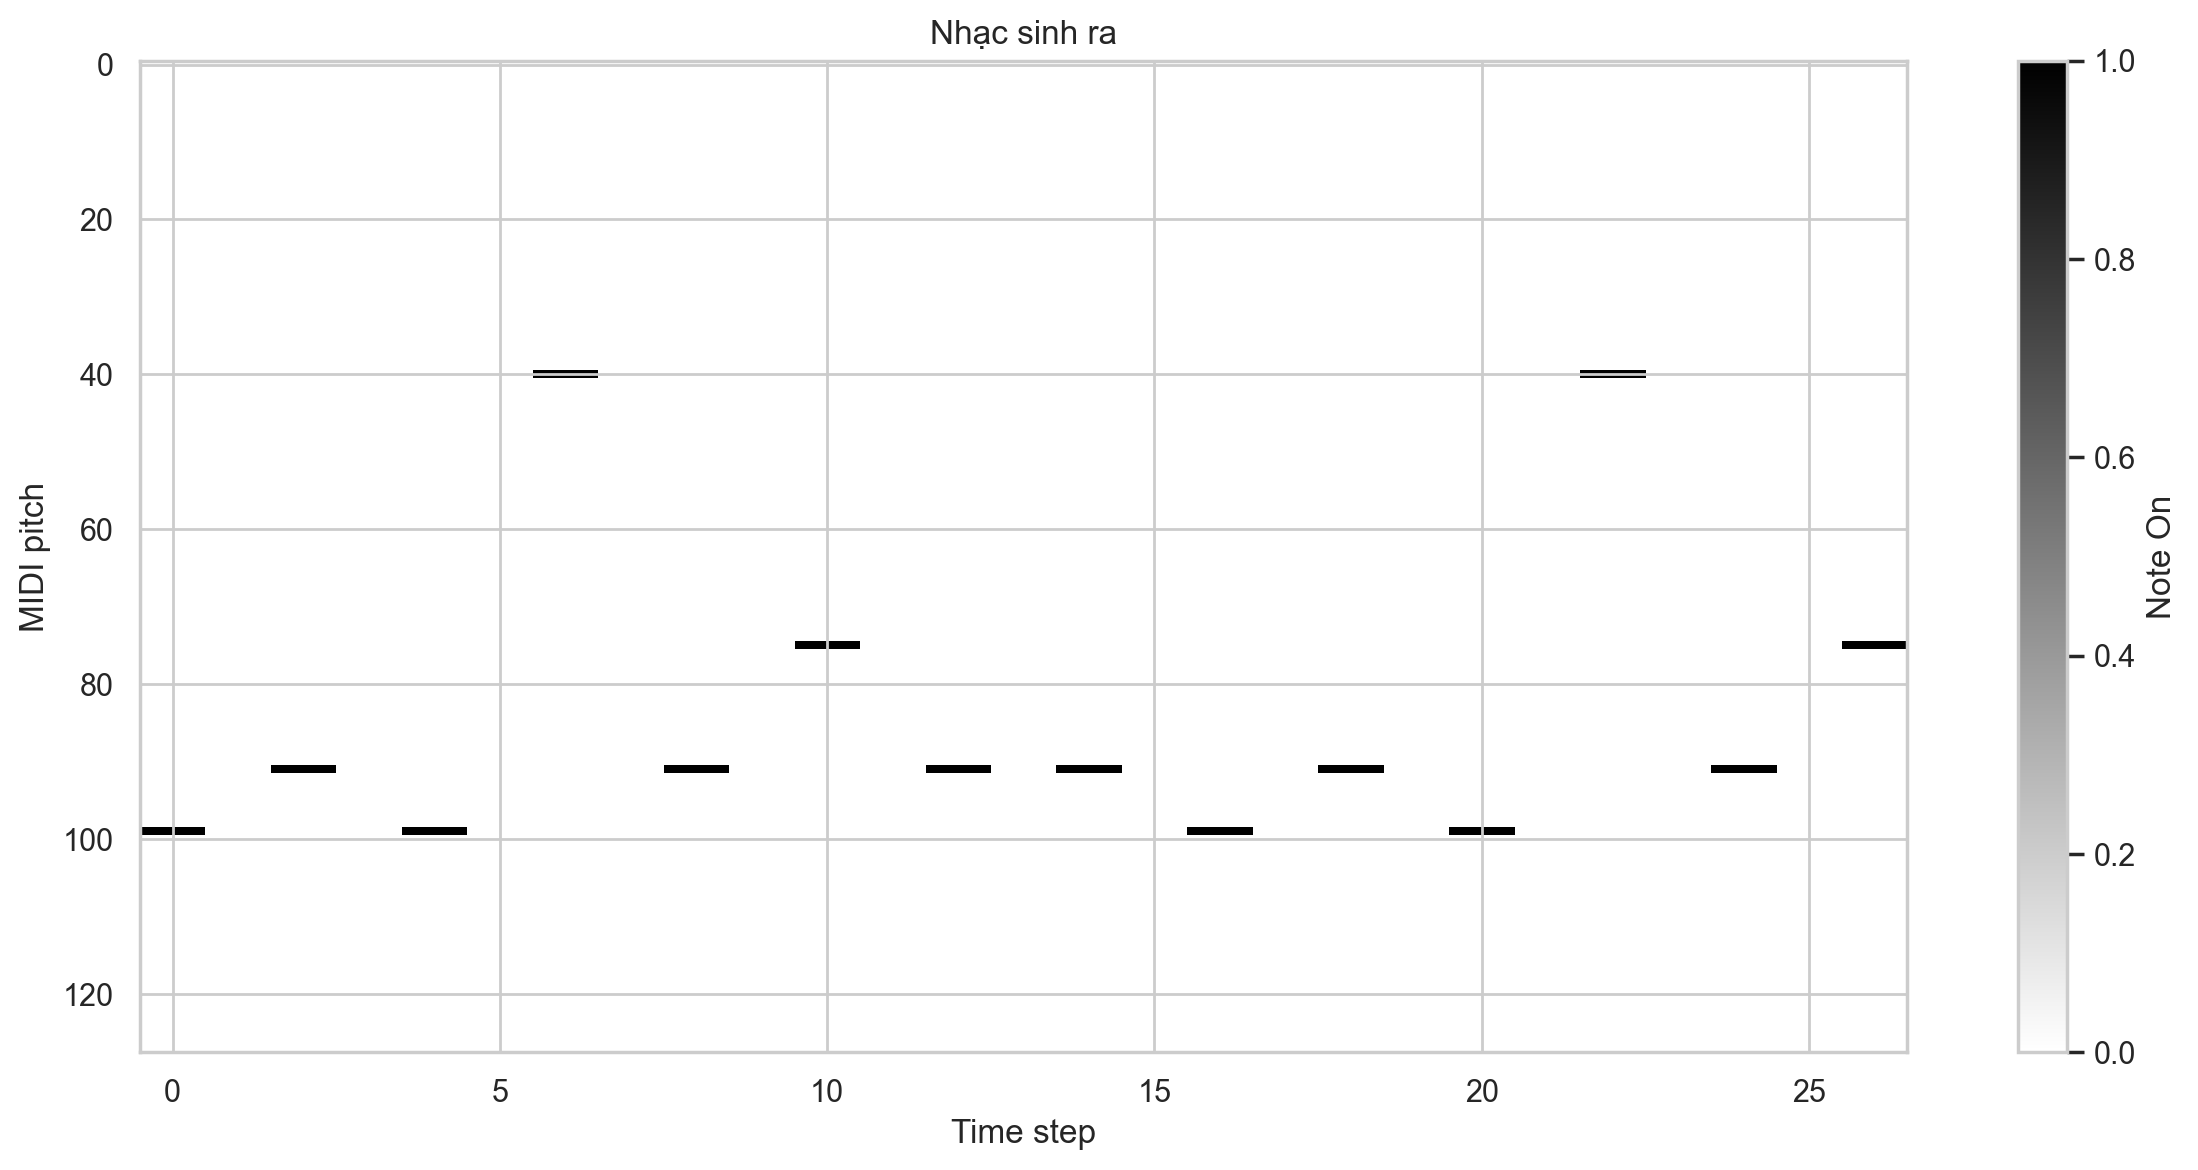

In [47]:
def extract_notes_from_midi(midi_path):
    midi = converter.parse(midi_path)

    parts = instrument.partitionByInstrument(midi)
    if parts:  # n·∫øu c√≥ nhi·ªÅu nh·∫°c c·ª•
        notes = parts.parts[0].recurse()
    else:
        notes = midi.flat.notes

    extracted_notes = []
    for element in notes:
        if isinstance(element, note.Note):
            extracted_notes.append((element.offset, element.pitch.midi))
        elif isinstance(element, chord.Chord):
            # V·ªõi chord, l·∫•y pitch trung b√¨nh (ho·∫∑c ch·ªçn n·ªët cao nh·∫•t/th·∫•p nh·∫•t)
            extracted_notes.append((element.offset, element.pitches[0].midi))
    return extracted_notes

def build_piano_roll(note_events, time_resolution=0.25):
    """
    T·∫°o piano roll t·ª´ danh s√°ch (offset, pitch)
    """
    if not note_events:
        return np.zeros((128, 1))

    max_time = max([offset for offset, pitch in note_events])
    num_steps = int(max_time / time_resolution) + 1
    piano_roll = np.zeros((128, num_steps))  # MIDI range: 0-127

    for offset, pitch in note_events:
        time_idx = int(offset / time_resolution)
        if 0 <= pitch < 128:
            piano_roll[pitch, time_idx] = 1
    return piano_roll

def plot_piano_roll(piano_roll, title="Piano Roll"):
    plt.figure(figsize=(12, 6))
    plt.imshow(piano_roll[::-1], aspect='auto', cmap='gray_r', interpolation='nearest')
    plt.title(title)
    plt.xlabel("Time step")
    plt.ylabel("MIDI pitch")
    plt.colorbar(label="Note On")
    plt.tight_layout()
    plt.show()


# üîç ƒê∆∞·ªùng d·∫´n ƒë·∫øn file MIDI g·ªëc v√† MIDI sinh ra
midi_real_path = "D:/CƒêE/data/Di·ªÖm x∆∞a.mid"  # ‚Üê thay b·∫±ng file nh·∫°c g·ªëc b·∫°n mu·ªën so s√°nh
midi_generated_path = "D:/CƒêE/test/generated_music_lstm_2.mid"

# üì• Tr√≠ch xu·∫•t n·ªët
notes_real = extract_notes_from_midi(midi_real_path)
notes_generated = extract_notes_from_midi(midi_generated_path)

piano_roll_real = build_piano_roll(notes_real)
piano_roll_generated = build_piano_roll(notes_generated)
plot_piano_roll(piano_roll_real, title="g·ªëc")
plot_piano_roll(piano_roll_generated, title="Nh·∫°c sinh ra")


üîé So s√°nh th·ªëng k√™ gi·ªØa nh·∫°c g·ªëc v√† nh·∫°c sinh:
S·ªë l∆∞·ª£ng n·ªët:		100 (g·ªëc) vs 14 (sinh)
Cao ƒë·ªô trung b√¨nh:	63.69 (g·ªëc) vs 43.29 (sinh)
ƒê·ªô d√†i b√†i h√°t:		50.00 s (g·ªëc) vs 7.00 s (sinh)
S·ªë cao ƒë·ªô kh√°c nhau:	18 (g·ªëc) vs 4 (sinh)


C:\Users\VuNgoc\AppData\Local\Temp\ipykernel_12192\3464485402.py:64: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) Arial.
  plt.tight_layout()
d:\CƒêE\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


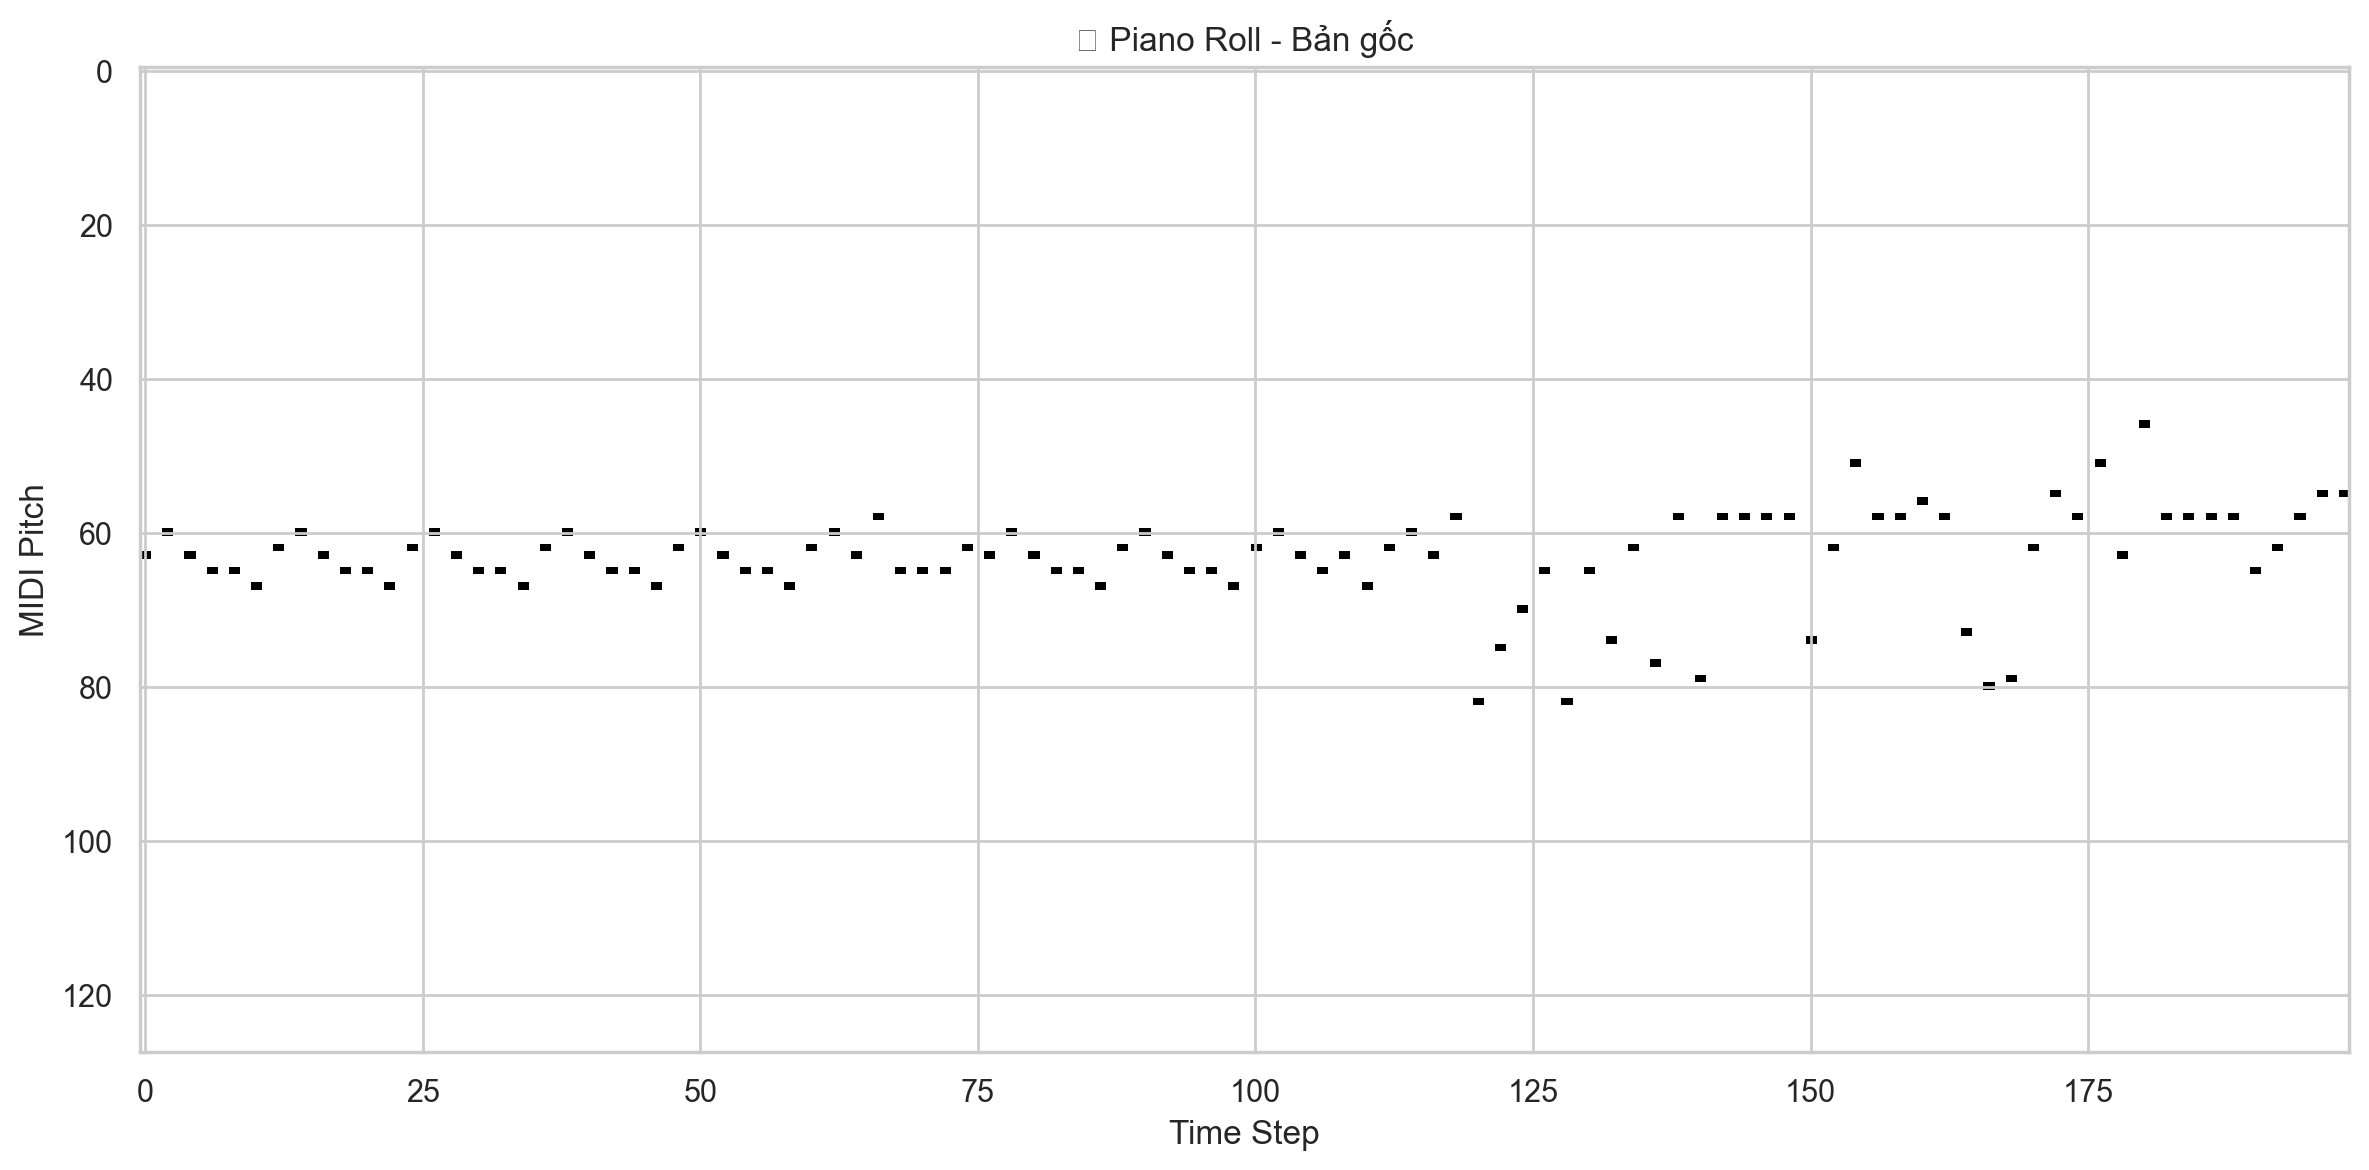

C:\Users\VuNgoc\AppData\Local\Temp\ipykernel_12192\3464485402.py:64: UserWarning: Glyph 127932 (\N{MUSICAL SCORE}) missing from font(s) Arial.
  plt.tight_layout()
d:\CƒêE\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127932 (\N{MUSICAL SCORE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


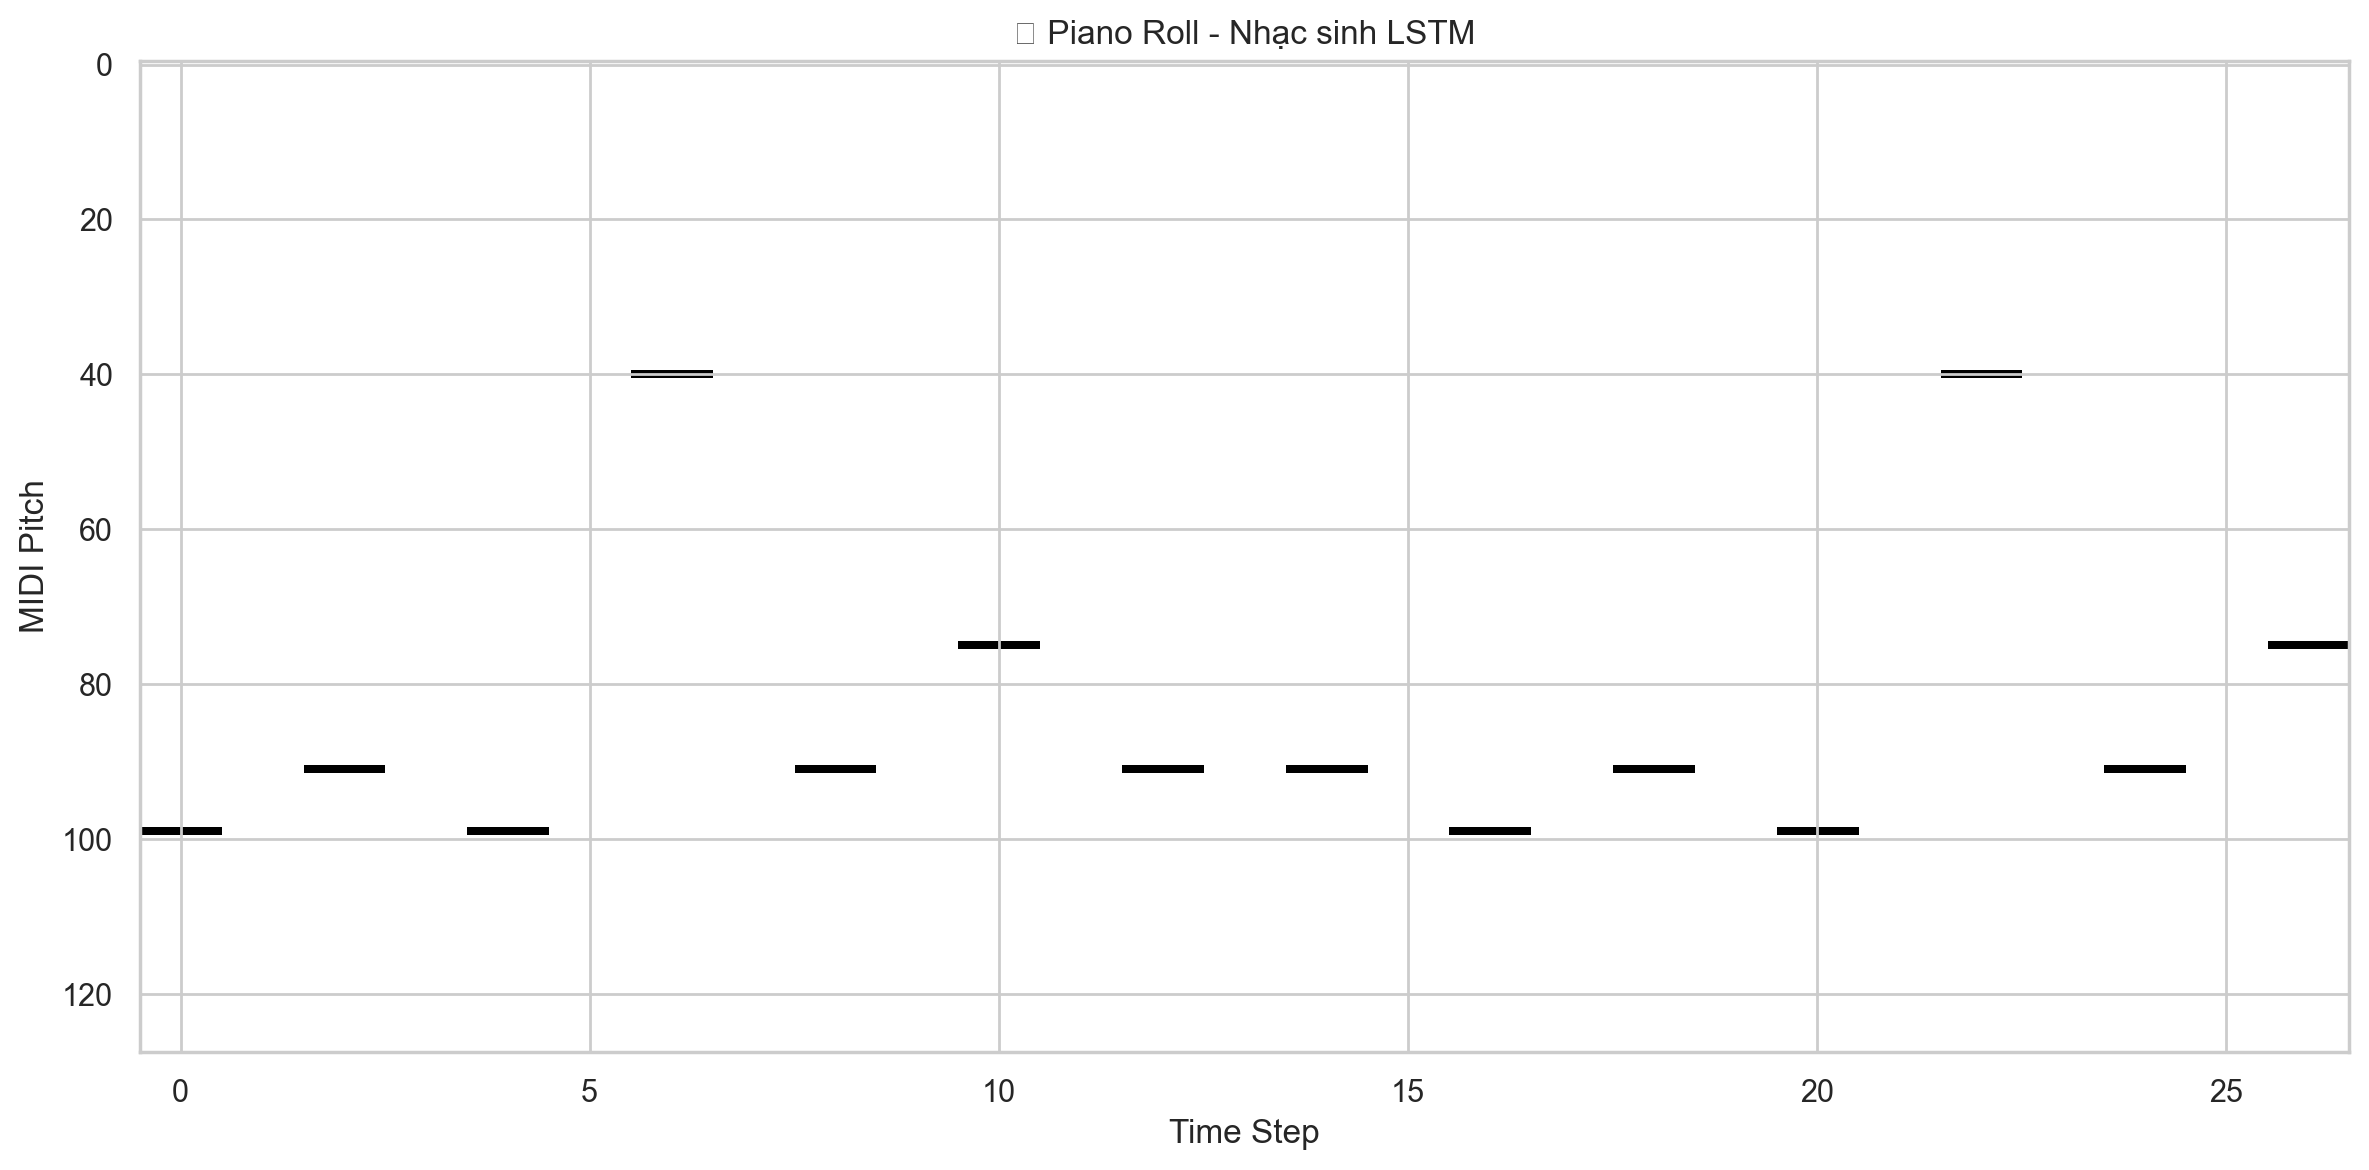

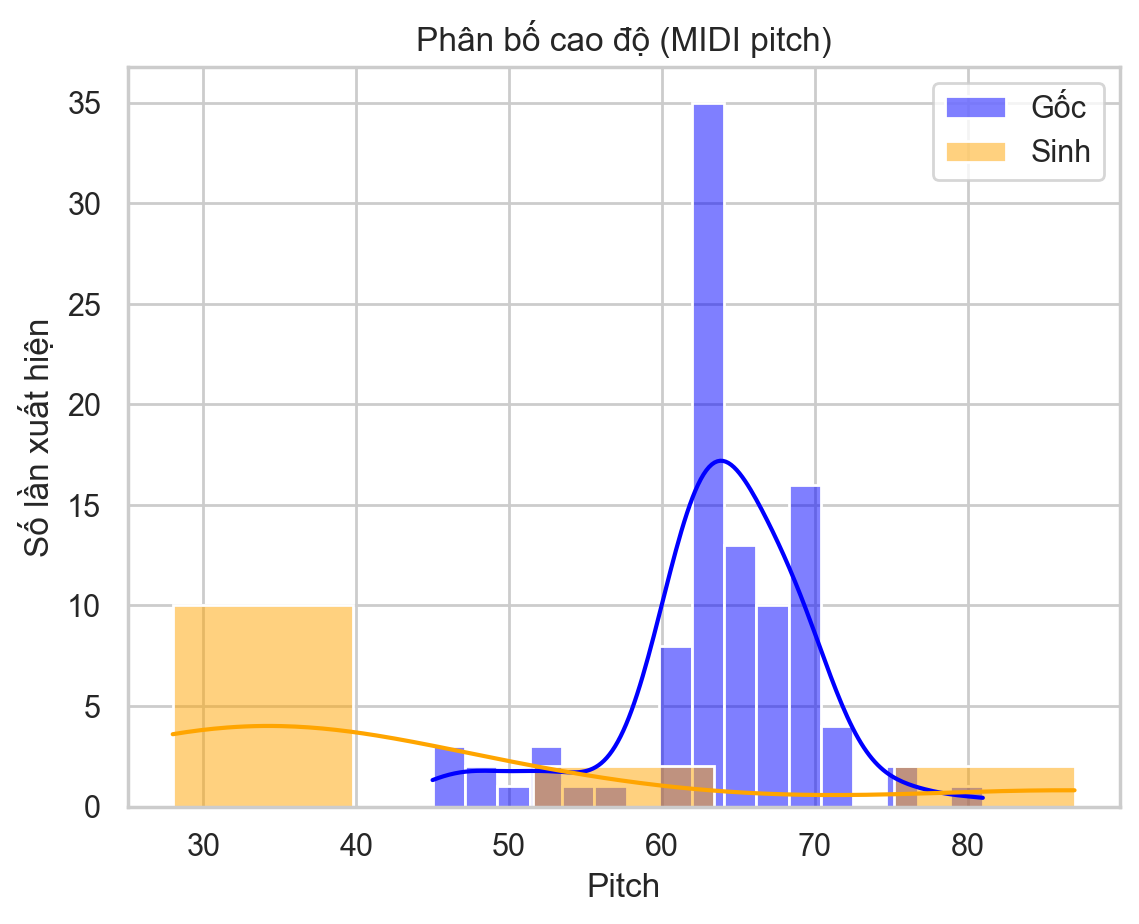

In [48]:
#So s√°nh MIDI m·ªõi vs c≈©
def extract_note_stats(midi_path):
    midi = converter.parse(midi_path)

    parts = instrument.partitionByInstrument(midi)
    if parts:
        elements = parts.parts[0].recurse()
    else:
        elements = midi.flat.notes

    pitches = []
    offsets = []
    durations = []

    for element in elements:
        if isinstance(element, note.Note):
            pitches.append(element.pitch.midi)
            offsets.append(element.offset)
            durations.append(element.quarterLength)
        elif isinstance(element, chord.Chord):
            pitches.append(element.pitches[0].midi)
            offsets.append(element.offset)
            durations.append(element.quarterLength)

    return {
        "num_notes": len(pitches),
        "unique_pitches": len(set(pitches)),
        "avg_pitch": np.mean(pitches) if pitches else 0,
        "duration": max(offsets) + durations[-1] if offsets else 0,
        "pitches": pitches
    }

def build_piano_roll(note_events, time_resolution=0.25):
    if not note_events:
        return np.zeros((128, 1))
    max_time = max([offset for offset, pitch in note_events])
    num_steps = int(max_time / time_resolution) + 1
    piano_roll = np.zeros((128, num_steps))
    for offset, pitch in note_events:
        time_idx = int(offset / time_resolution)
        if 0 <= pitch < 128:
            piano_roll[pitch, time_idx] = 1
    return piano_roll

def extract_events(midi_path):
    midi = converter.parse(midi_path)
    parts = instrument.partitionByInstrument(midi)
    notes = parts.parts[0].recurse() if parts else midi.flat.notes

    events = []
    for element in notes:
        if isinstance(element, note.Note):
            events.append((element.offset, element.pitch.midi))
        elif isinstance(element, chord.Chord):
            events.append((element.offset, element.pitches[0].midi))
    return events

def plot_piano_roll(piano_roll, title):
    plt.figure(figsize=(12, 6))
    plt.imshow(piano_roll[::-1], aspect='auto', cmap='gray_r', interpolation='nearest')
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("MIDI Pitch")
    plt.tight_layout()
    plt.show()

def compare_and_plot(real_path, generated_path):
    # So s√°nh ƒë·∫∑c tr∆∞ng
    real_stats = extract_note_stats(real_path)
    gen_stats = extract_note_stats(generated_path)

    print("üîé So s√°nh th·ªëng k√™ gi·ªØa nh·∫°c g·ªëc v√† nh·∫°c sinh:")
    print(f"S·ªë l∆∞·ª£ng n·ªët:\t\t{real_stats['num_notes']} (g·ªëc) vs {gen_stats['num_notes']} (sinh)")
    print(f"Cao ƒë·ªô trung b√¨nh:\t{real_stats['avg_pitch']:.2f} (g·ªëc) vs {gen_stats['avg_pitch']:.2f} (sinh)")
    print(f"ƒê·ªô d√†i b√†i h√°t:\t\t{real_stats['duration']:.2f} s (g·ªëc) vs {gen_stats['duration']:.2f} s (sinh)")
    print(f"S·ªë cao ƒë·ªô kh√°c nhau:\t{real_stats['unique_pitches']} (g·ªëc) vs {gen_stats['unique_pitches']} (sinh)")

    # Piano roll
    real_events = extract_events(real_path)
    gen_events = extract_events(generated_path)

    real_roll = build_piano_roll(real_events)
    gen_roll = build_piano_roll(gen_events)

    plot_piano_roll(real_roll, "üéµ Piano Roll - B·∫£n g·ªëc")
    plot_piano_roll(gen_roll, "üéº Piano Roll - Nh·∫°c sinh LSTM")

    # Bi·ªÉu ƒë·ªì ph√¢n b·ªë cao ƒë·ªô
    sns.histplot(real_stats["pitches"], color="blue", label="G·ªëc", kde=True)
    sns.histplot(gen_stats["pitches"], color="orange", label="Sinh", kde=True)
    plt.title("Ph√¢n b·ªë cao ƒë·ªô (MIDI pitch)")
    plt.xlabel("Pitch")
    plt.ylabel("S·ªë l·∫ßn xu·∫•t hi·ªán")
    plt.legend()
    plt.show()


# üëâ D√πng h√†m so s√°nh
compare_and_plot(
    real_path="D:/CƒêE/test/generated_music_lstm.mid",
    generated_path="D:/CƒêE/test/generated_music_lstm_2.mid"
)


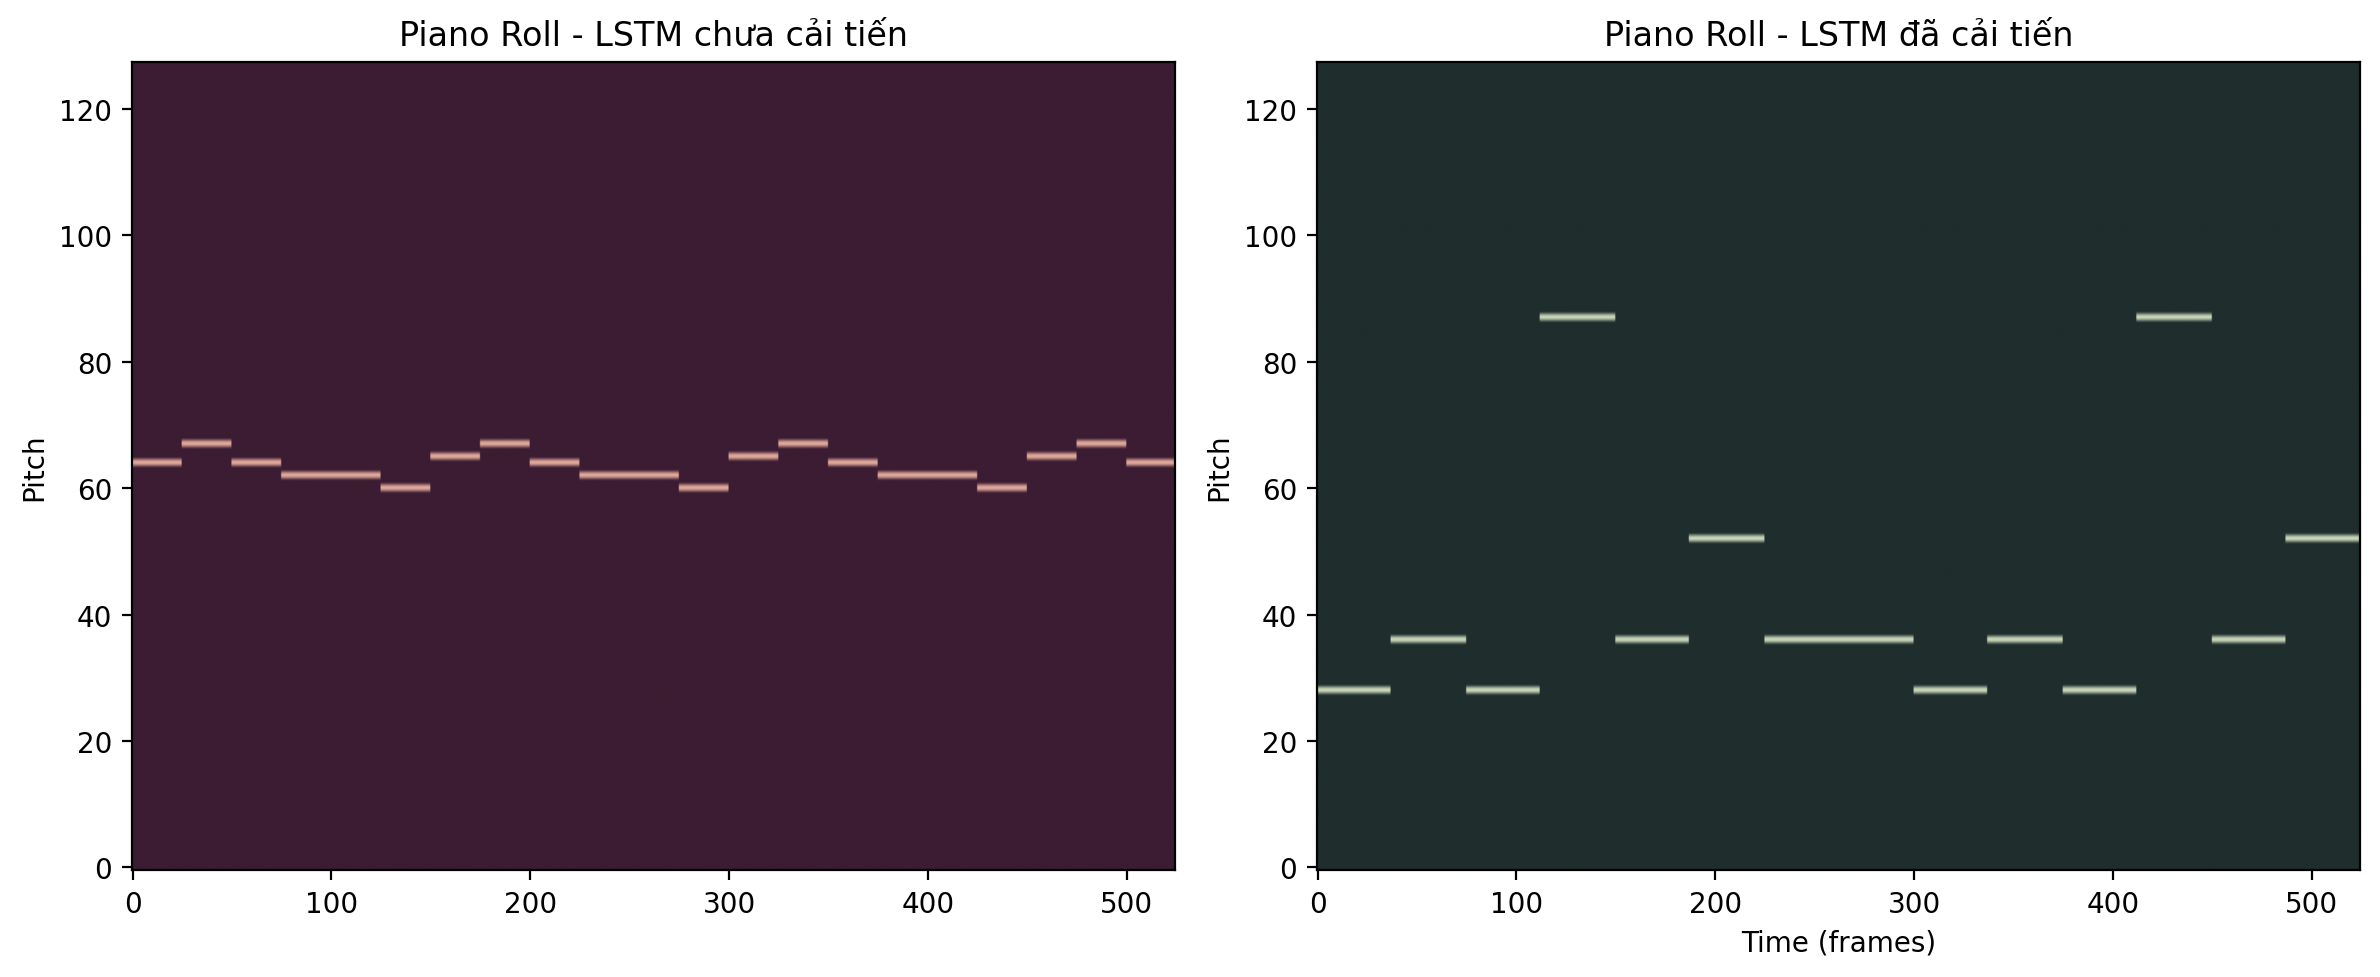

In [12]:
from matplotlib.colors import LinearSegmentedColormap

# T·∫°o colormap nh·∫π nh√†ng
ts_color_1 = LinearSegmentedColormap.from_list("trinh_color_1", ["#3b1c32", "#a26769", "#e0a899"])
ts_color_2 = LinearSegmentedColormap.from_list("trinh_color_2", ["#1f2d2d", "#4a7c59", "#c8d5b9"])

# V·∫Ω piano roll
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

axs[0].imshow(piano_roll_1, aspect='auto', origin='lower', cmap=ts_color_1)
axs[0].set_title("Piano Roll - LSTM ch∆∞a c·∫£i ti·∫øn", fontsize=12)
axs[0].set_ylabel("Pitch")

axs[1].imshow(piano_roll_2, aspect='auto', origin='lower', cmap=ts_color_2)
axs[1].set_title("Piano Roll - LSTM ƒë√£ c·∫£i ti·∫øn", fontsize=12)
axs[1].set_xlabel("Time (frames)")
axs[1].set_ylabel("Pitch")

plt.tight_layout()
plt.show()


M√î H√åNH VAE


In [18]:
# T·∫£i d·ªØ li·ªáu MIDI ƒë√£ x·ª≠ l√Ω
with open("D:/CƒêE/test/midi_data_music21.pkl", "rb") as f:
    loaded_data = pickle.load(f)

# T·∫°o mapping gi·ªØa n·ªët nh·∫°c v√† s·ªë nguy√™n
all_notes = sorted(set(note["pitch"] for song in loaded_data for note in song))
note_to_int = {note: i + 1 for i, note in enumerate(all_notes)}
int_to_note = {i + 1: note for i, note in enumerate(all_notes)}
num_notes = len(note_to_int) + 1  # +1 ƒë·ªÉ tr√°nh l·ªói mapping

# Chu·∫©n b·ªã d·ªØ li·ªáu ƒë·∫ßu v√†o
seq_length = 100  # ƒê·ªô d√†i m·ªói chu·ªói ƒë·∫ßu v√†o
X = []

for song in loaded_data:
    notes = np.array([note_to_int.get(note["pitch"], 0) for note in song])
    for i in range(len(notes) - seq_length):
        X.append(notes[i:i + seq_length])

X = np.array(X).reshape(len(X), seq_length, 1)  # ƒê·ªãnh d·∫°ng l·∫°i th√†nh (samples, time steps, features)

# Chia d·ªØ li·ªáu th√†nh t·∫≠p hu·∫•n luy·ªán v√† ki·ªÉm tra
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]

print(f"Size of training data: {X_train.shape}")
print(f"Size of test data: {X_test.shape}")

Size of training data: (19777, 100, 1)
Size of test data: (4945, 100, 1)


In [45]:
latent_dim = 16  # K√≠ch th∆∞·ªõc kh√¥ng gian ti·ªÅm ·∫©n

# ENCODER
inputs = Input(shape=(seq_length, 1))
x = LSTM(128, return_sequences=True)(inputs)
x = LSTM(64, return_sequences=False)(x)
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)

# H√†m sampling t·ª´ ph√¢n ph·ªëi Gaussian
def sampling(args):
    z_mean, z_log_var = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = tf.random.normal(shape=(batch_size, latent_dim), mean=0.0, stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

# DECODER
decoder_input = Input(shape=(latent_dim,))
x = RepeatVector(seq_length)(decoder_input)
x = LSTM(64, return_sequences=True)(x)
x = LSTM(128, return_sequences=True)(x)
outputs = TimeDistributed(Dense(num_notes, activation="softmax"))(x)

# M√¥ h√¨nh encoder v√† decoder
encoder = Model(inputs, [z_mean, z_log_var, z], name="Encoder")
decoder = Model(decoder_input, outputs, name="Decoder")

vae_outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, vae_outputs, name="VAE")

# H√†m KL loss
def vae_kl_loss(z_mean, z_log_var):
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return kl_loss

class KLLossLayer(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = tf.reduce_mean(vae_kl_loss(z_mean, z_log_var))
        self.add_loss(kl_loss)  # Th√™m loss tr·ª±c ti·∫øp trong Layer
        return inputs  # Tr·∫£ l·∫°i ƒë·∫ßu v√†o kh√¥ng thay ƒë·ªïi

kl_loss_layer = KLLossLayer()([z_mean, z_log_var])
vae.compile(optimizer=tf.keras.optimizers.Adam(), loss="sparse_categorical_crossentropy")
# Hu·∫•n luy·ªán m√¥ h√¨nh VAE
history_vae = vae.fit(X_train, X_train, epochs=50, batch_size=64, validation_data=(X_test, X_test))
# L∆∞u m√¥ h√¨nh ƒë√£ hu·∫•n luy·ªán
vae.save("D:/CƒêE/test/music_vae.h5")
encoder.save("D:/CƒêE/test/music_encoder.h5")
decoder.save("D:/CƒêE/test/music_decoder.h5")

print("M√¥ h√¨nh ƒë√£ ƒë∆∞·ª£c hu·∫•n luy·ªán v√† l∆∞u.")

Epoch 1/50
310/310 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 155s 454ms/step - loss: 3.6157 - val_loss: 3.8780
Epoch 2/50
310/310 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 146s 470ms/step - loss: 3.4939 - val_loss: 3.8528
Epoch 3/50
310/310 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 152s 491ms/step - loss: 3.4382 - val_loss: 3.8379
Epoch 4/50
310/310 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 184s 433ms/step - loss: 3.4024 - val_loss: 4.0832
Epoch 5/50
310/310 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 138s 444ms/step - loss: 3.4995 - val_loss: 3.9072
Epoch 6/50
310/310 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 141s 442ms/step - loss: 3.3105 - val_loss: 3.7036
Epoch 7/50
310/310 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 137s 443ms/step - loss: 3.2163 - val_loss: 3.8277
Epoch 8/50
310/310 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 146s 470ms

M√¥ h√¨nh ƒë√£ ƒë∆∞·ª£c hu·∫•n luy·ªán v√† l∆∞u.


In [46]:
# H√†m sinh nh·∫°c t·ª´ latent vector
def generate_music_from_latent(decoder, latent_vector, num_notes=80):
    generated_notes = decoder.predict(latent_vector)
    generated_notes = np.argmax(generated_notes, axis=-1)  # Chuy·ªÉn th√†nh ch·ªâ s·ªë n·ªët nh·∫°c
    return generated_notes.flatten()[:num_notes]  # Tr·∫£ v·ªÅ 80 n·ªët nh·∫°c

# T·∫°o latent vector t·ª´ encoder
sample_song = np.expand_dims(X_train[0], axis=0)  # Ch·ªçn m·ªôt chu·ªói nh·∫°c ƒë·∫ßu v√†o t·ª´ t·∫≠p hu·∫•n luy·ªán
latent_vector = encoder.predict(sample_song)[2]  # L·∫•y latent vector t·ª´ encoder

# Sinh nh·∫°c t·ª´ latent vector
generated_notes = generate_music_from_latent(decoder, latent_vector)

# √Ånh x·∫° ch·ªâ s·ªë n·ªët nh·∫°c sang t√™n n·ªët nh·∫°c
note_mapping = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
def map_to_notes(indices):
    return [note_mapping[int(i) % len(note_mapping)] for i in np.array(indices).flatten()]

# √Ånh x·∫° n·ªët nh·∫°c sinh ra
mapped_notes = map_to_notes(generated_notes)

# Gi·ªõi h·∫°n thang √¢m Tr·ªãnh C√¥ng S∆°n
trinh_scale = ["C", "D", "E", "G", "A", "Bb", "F"]
def generate_trinh_music(mapped_notes):
    processed_notes = []
    for note in mapped_notes:
        if note not in trinh_scale:
            note = np.random.choice(trinh_scale)  # ƒêi·ªÅu ch·ªânh v·ªÅ thang √¢m Tr·ªãnh
        processed_notes.append(note)
    return processed_notes

# Sinh nh·∫°c theo phong c√°ch Tr·ªãnh C√¥ng S∆°n
trinh_music_notes = generate_trinh_music(mapped_notes)

# T·∫°o file MIDI t·ª´ nh·∫°c ƒë√£ sinh ra
import music21

midi_stream = music21.stream.Stream()
midi_stream.append(music21.tempo.MetronomeMark(number=90))  # Tempo 90 BPM

# Ch·ªçn th·ªùi gian cho t·ª´ng n·ªët nh·∫°c
total_duration = 0
for note_name in trinh_music_notes:
    n = music21.note.Note(note_name)
    duration = np.random.choice([0.5, 1, 1.5], p=[0.4, 0.4, 0.2])  # N·ªët d√†i 0.5s, 1s ho·∫∑c 1.5s
    n.quarterLength = duration
    midi_stream.append(n)
    total_duration += duration * (60 / 90)  # T√≠nh to√°n th·ªùi gian t·ªïng
    if total_duration >= 25:  # D·ª´ng khi ƒë·∫°t 25s
        break

# Xu·∫•t ra file MIDI
output_midi = "D:/CƒêE/test/generated_trinh_music_vae.mid"
midi_stream.write("midi", fp=output_midi)

print(f"Nh·∫°c Tr·ªãnh ƒë√£ ƒë∆∞·ª£c t·∫°o v√† l∆∞u t·∫°i {output_midi}! Th·ªùi gian ∆∞·ªõc t√≠nh: {round(total_duration, 2)}s")


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 561ms/step
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step
Nh·∫°c Tr·ªãnh ƒë√£ ƒë∆∞·ª£c t·∫°o v√† l∆∞u t·∫°i D:/CƒêE/test/generated_trinh_music_vae.mid! Th·ªùi gian ∆∞·ªõc t√≠nh: 25.67s


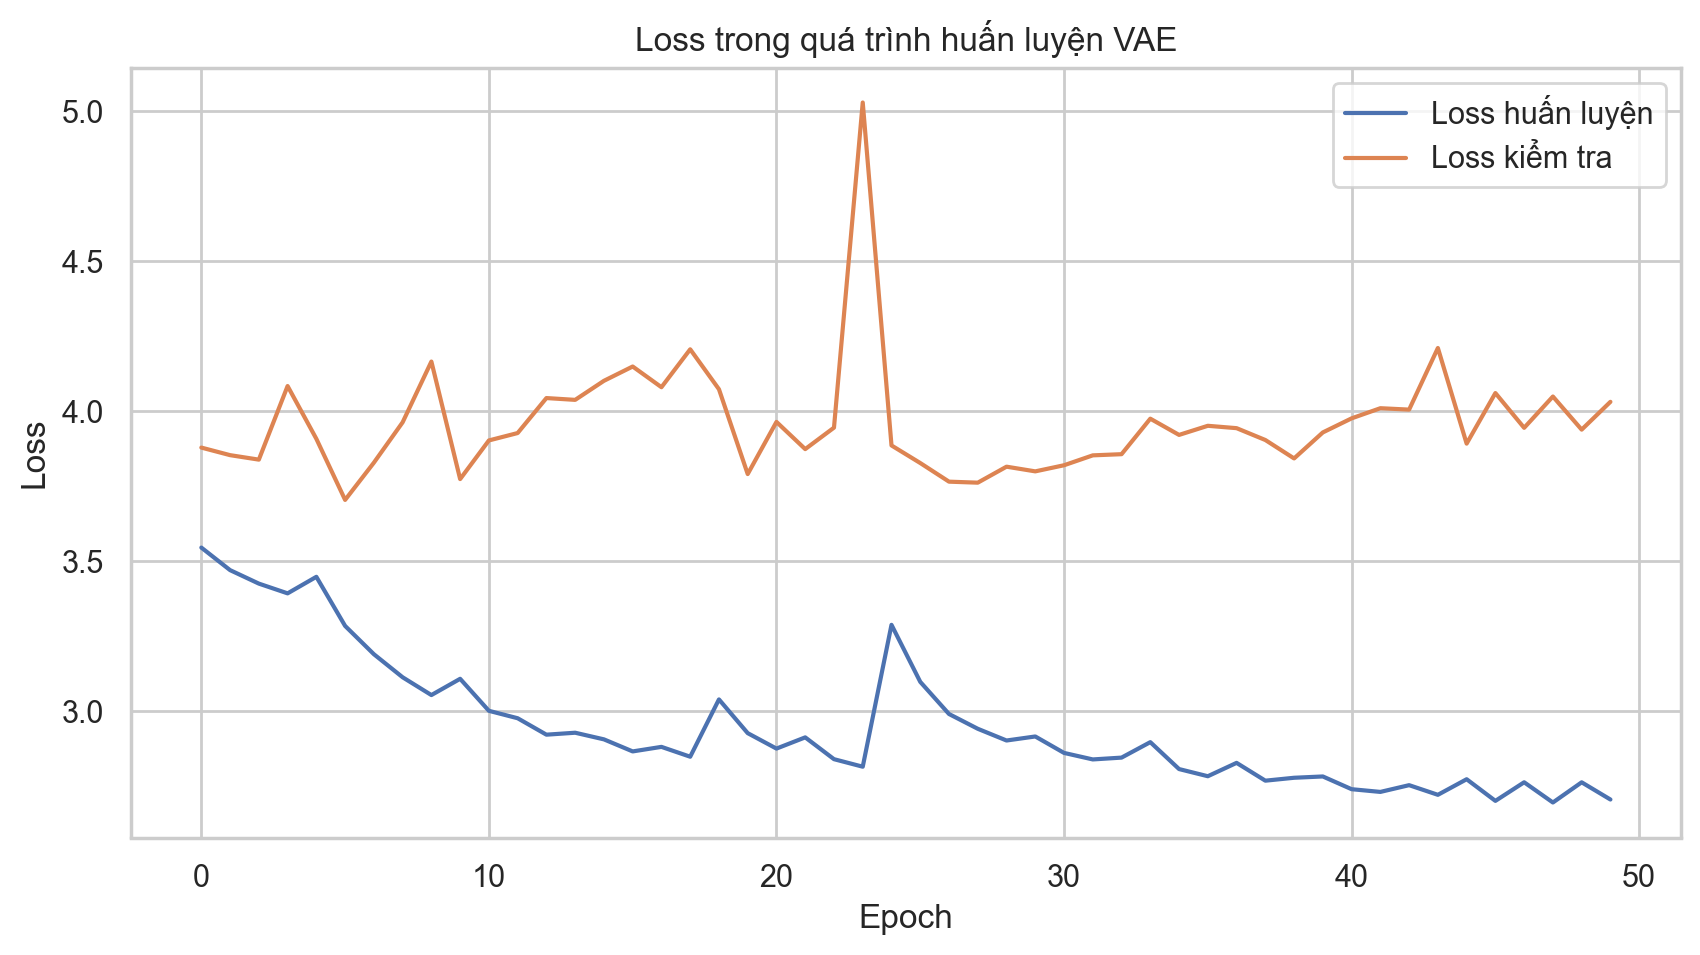

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history_vae.history['loss'], label='Loss hu·∫•n luy·ªán')
plt.plot(history_vae.history['val_loss'], label='Loss ki·ªÉm tra')
plt.title('Loss trong qu√° tr√¨nh hu·∫•n luy·ªán VAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# L·∫•y 1000 sample t·ª´ t·∫≠p hu·∫•n luy·ªán ƒë·ªÉ tr·ª±c quan h√≥a
sample_data = X_train[:1000]
z_mean_vals = encoder.predict(sample_data)[0]  # z_mean ƒë∆∞·ª£c d√πng ƒë·ªÉ bi·ªÉu di·ªÖn kh√¥ng gian ti·ªÅm ·∫©n

print(f"Shape of latent vectors: {z_mean_vals.shape}")


NameError: name 'encoder' is not defined

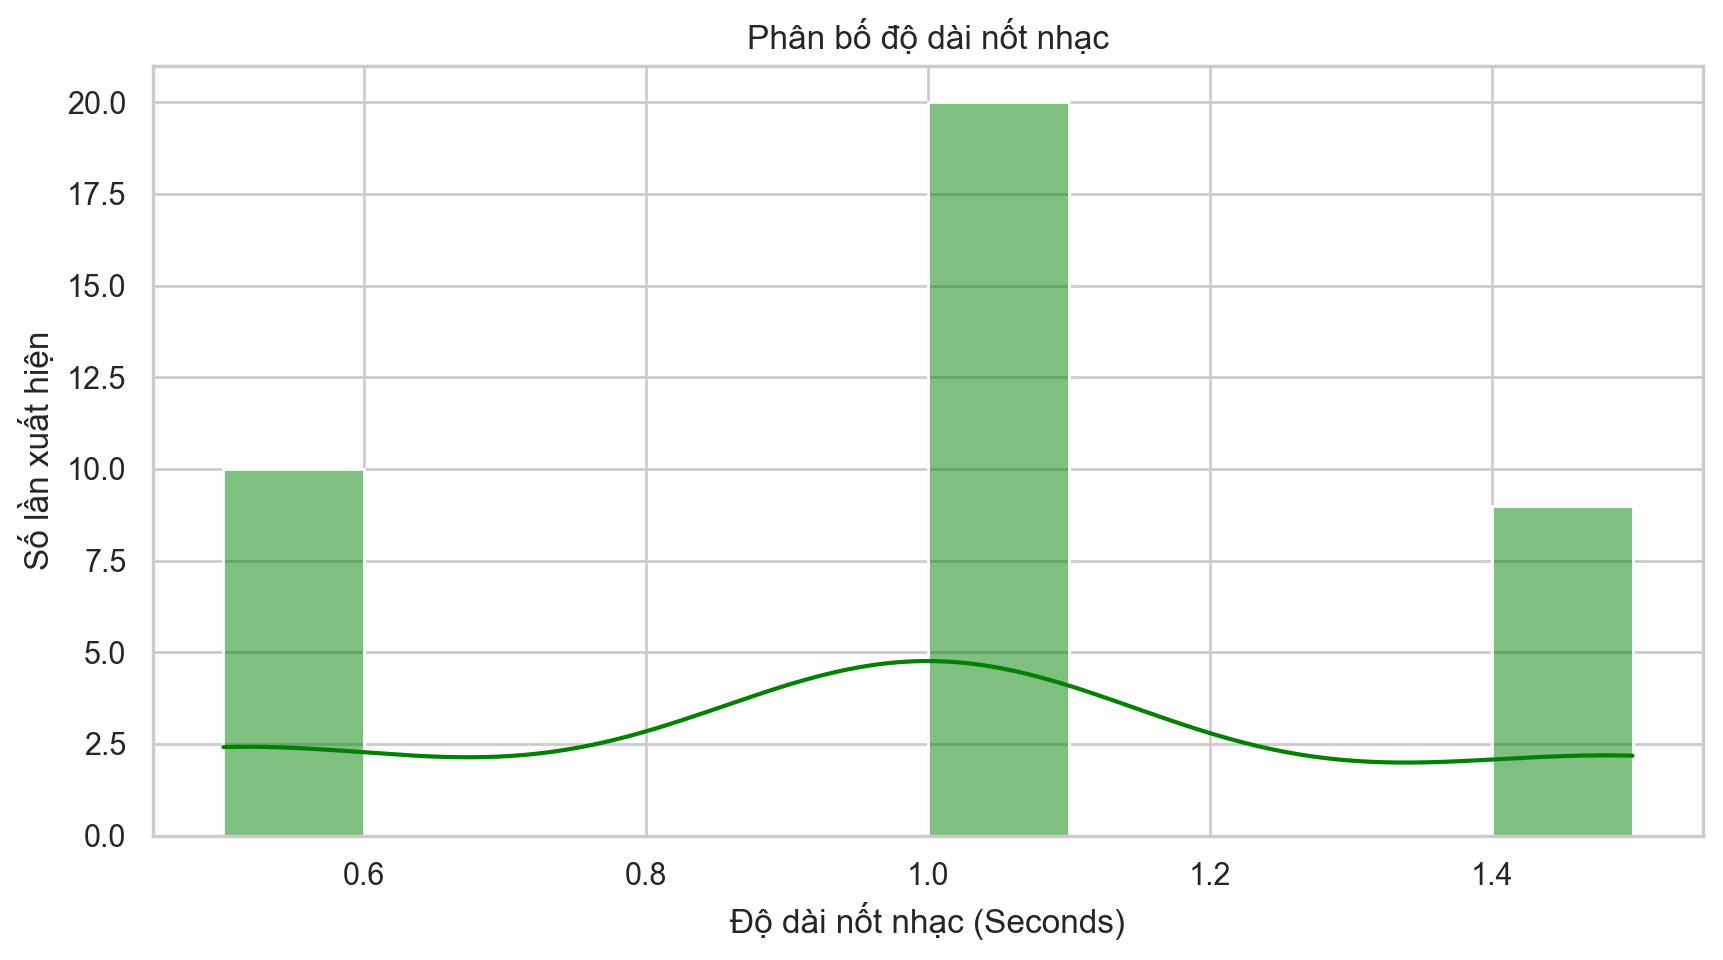

In [55]:
# V·∫Ω bi·ªÉu ƒë·ªì ph√¢n b·ªë ƒë·ªô d√†i n·ªët nh·∫°c (Duration Distribution)
durations = [n.quarterLength for n in midi_stream.notes]  # L·∫•y ƒë·ªô d√†i n·ªët t·ª´ file MIDI
plt.figure(figsize=(10, 5))
sns.histplot(durations, bins=10, kde=True, color="green")
plt.xlabel("ƒê·ªô d√†i n·ªët nh·∫°c (Seconds)")
plt.ylabel("S·ªë l·∫ßn xu·∫•t hi·ªán")
plt.title("Ph√¢n b·ªë ƒë·ªô d√†i n·ªët nh·∫°c")
plt.show()

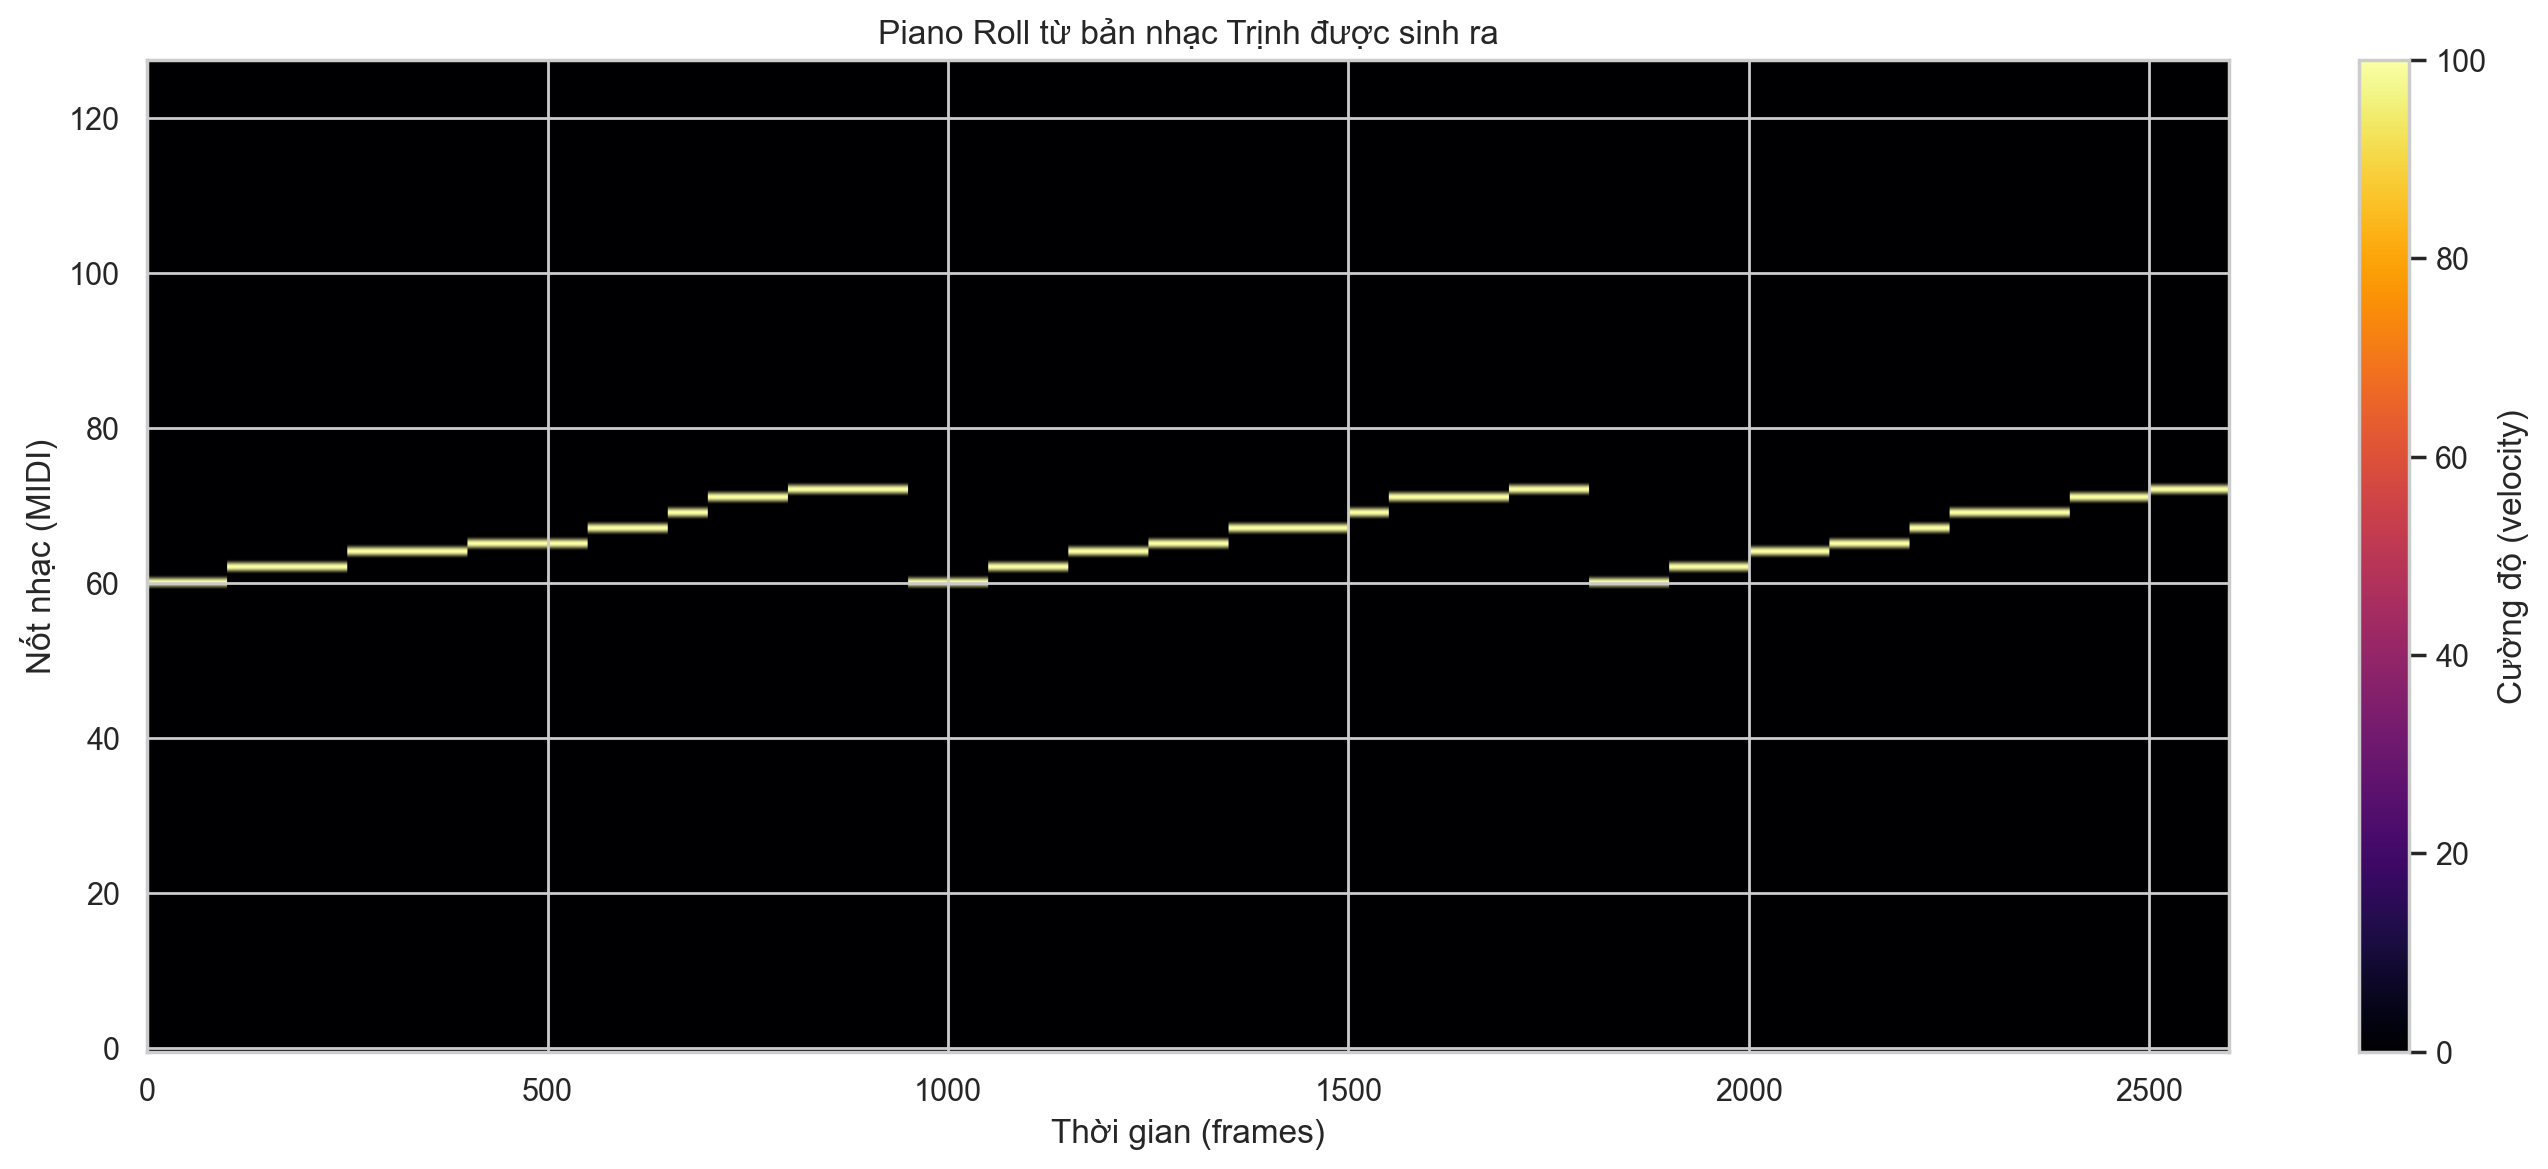

In [58]:
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt

def generate_piano_roll(note_list, output_path="piano_roll.png"):
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)  # Acoustic Grand Piano

    start = 0.0
    for n in note_list:
        try:
            midi_number = pretty_midi.note_name_to_number(n)
            duration = np.random.choice([0.5, 1.0, 1.5], p=[0.4, 0.4, 0.2])
            note_obj = pretty_midi.Note(velocity=100, pitch=midi_number,
                                        start=start, end=start + duration)
            instrument.notes.append(note_obj)
            start += duration
        except:
            continue  # B·ªè qua n·∫øu t√™n n·ªët kh√¥ng h·ª£p l·ªá

    pm.instruments.append(instrument)

    # V·∫Ω piano roll
    piano_roll = pm.get_piano_roll(fs=100)
    plt.figure(figsize=(14, 6))
    plt.imshow(piano_roll, aspect='auto', origin='lower', cmap='inferno')
    plt.title("Piano Roll t·ª´ b·∫£n nh·∫°c Tr·ªãnh ƒë∆∞·ª£c sinh ra")
    plt.xlabel("Th·ªùi gian (frames)")
    plt.ylabel("N·ªët nh·∫°c (MIDI)")
    plt.colorbar(label="C∆∞·ªùng ƒë·ªô (velocity)")
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

# G·ªçi h√†m v·ªõi danh s√°ch n·ªët b·∫°n ƒë√£ sinh
trinh_notes = ['C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4', 'C5'] * 3

generate_piano_roll(trinh_notes)


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 77ms/step


C:\Users\VuNgoc\AppData\Local\Temp\ipykernel_12192\3728999955.py:42: UserWarning: Glyph 127932 (\N{MUSICAL SCORE}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\VuNgoc\AppData\Local\Temp\ipykernel_12192\3728999955.py:42: UserWarning: Glyph 127929 (\N{MUSICAL KEYBOARD}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\VuNgoc\AppData\Local\Temp\ipykernel_12192\3728999955.py:42: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\VuNgoc\AppData\Local\Temp\ipykernel_12192\3728999955.py:43: UserWarning: Glyph 127932 (\N{MUSICAL SCORE}) missing from font(s) Arial.
  plt.savefig("vae_piano_roll_comparison.png", dpi=300)
C:\Users\VuNgoc\AppData\Local\Temp\ipykernel_12192\3728999955.py:43: UserWarning: Glyph 127929 (\N{MUSICAL KEYBOARD}) missing from font(s) Arial.
  plt.savefig("vae_piano_roll_comparison.png", dpi=300)
C:\Users\VuNgoc\AppData\Loc

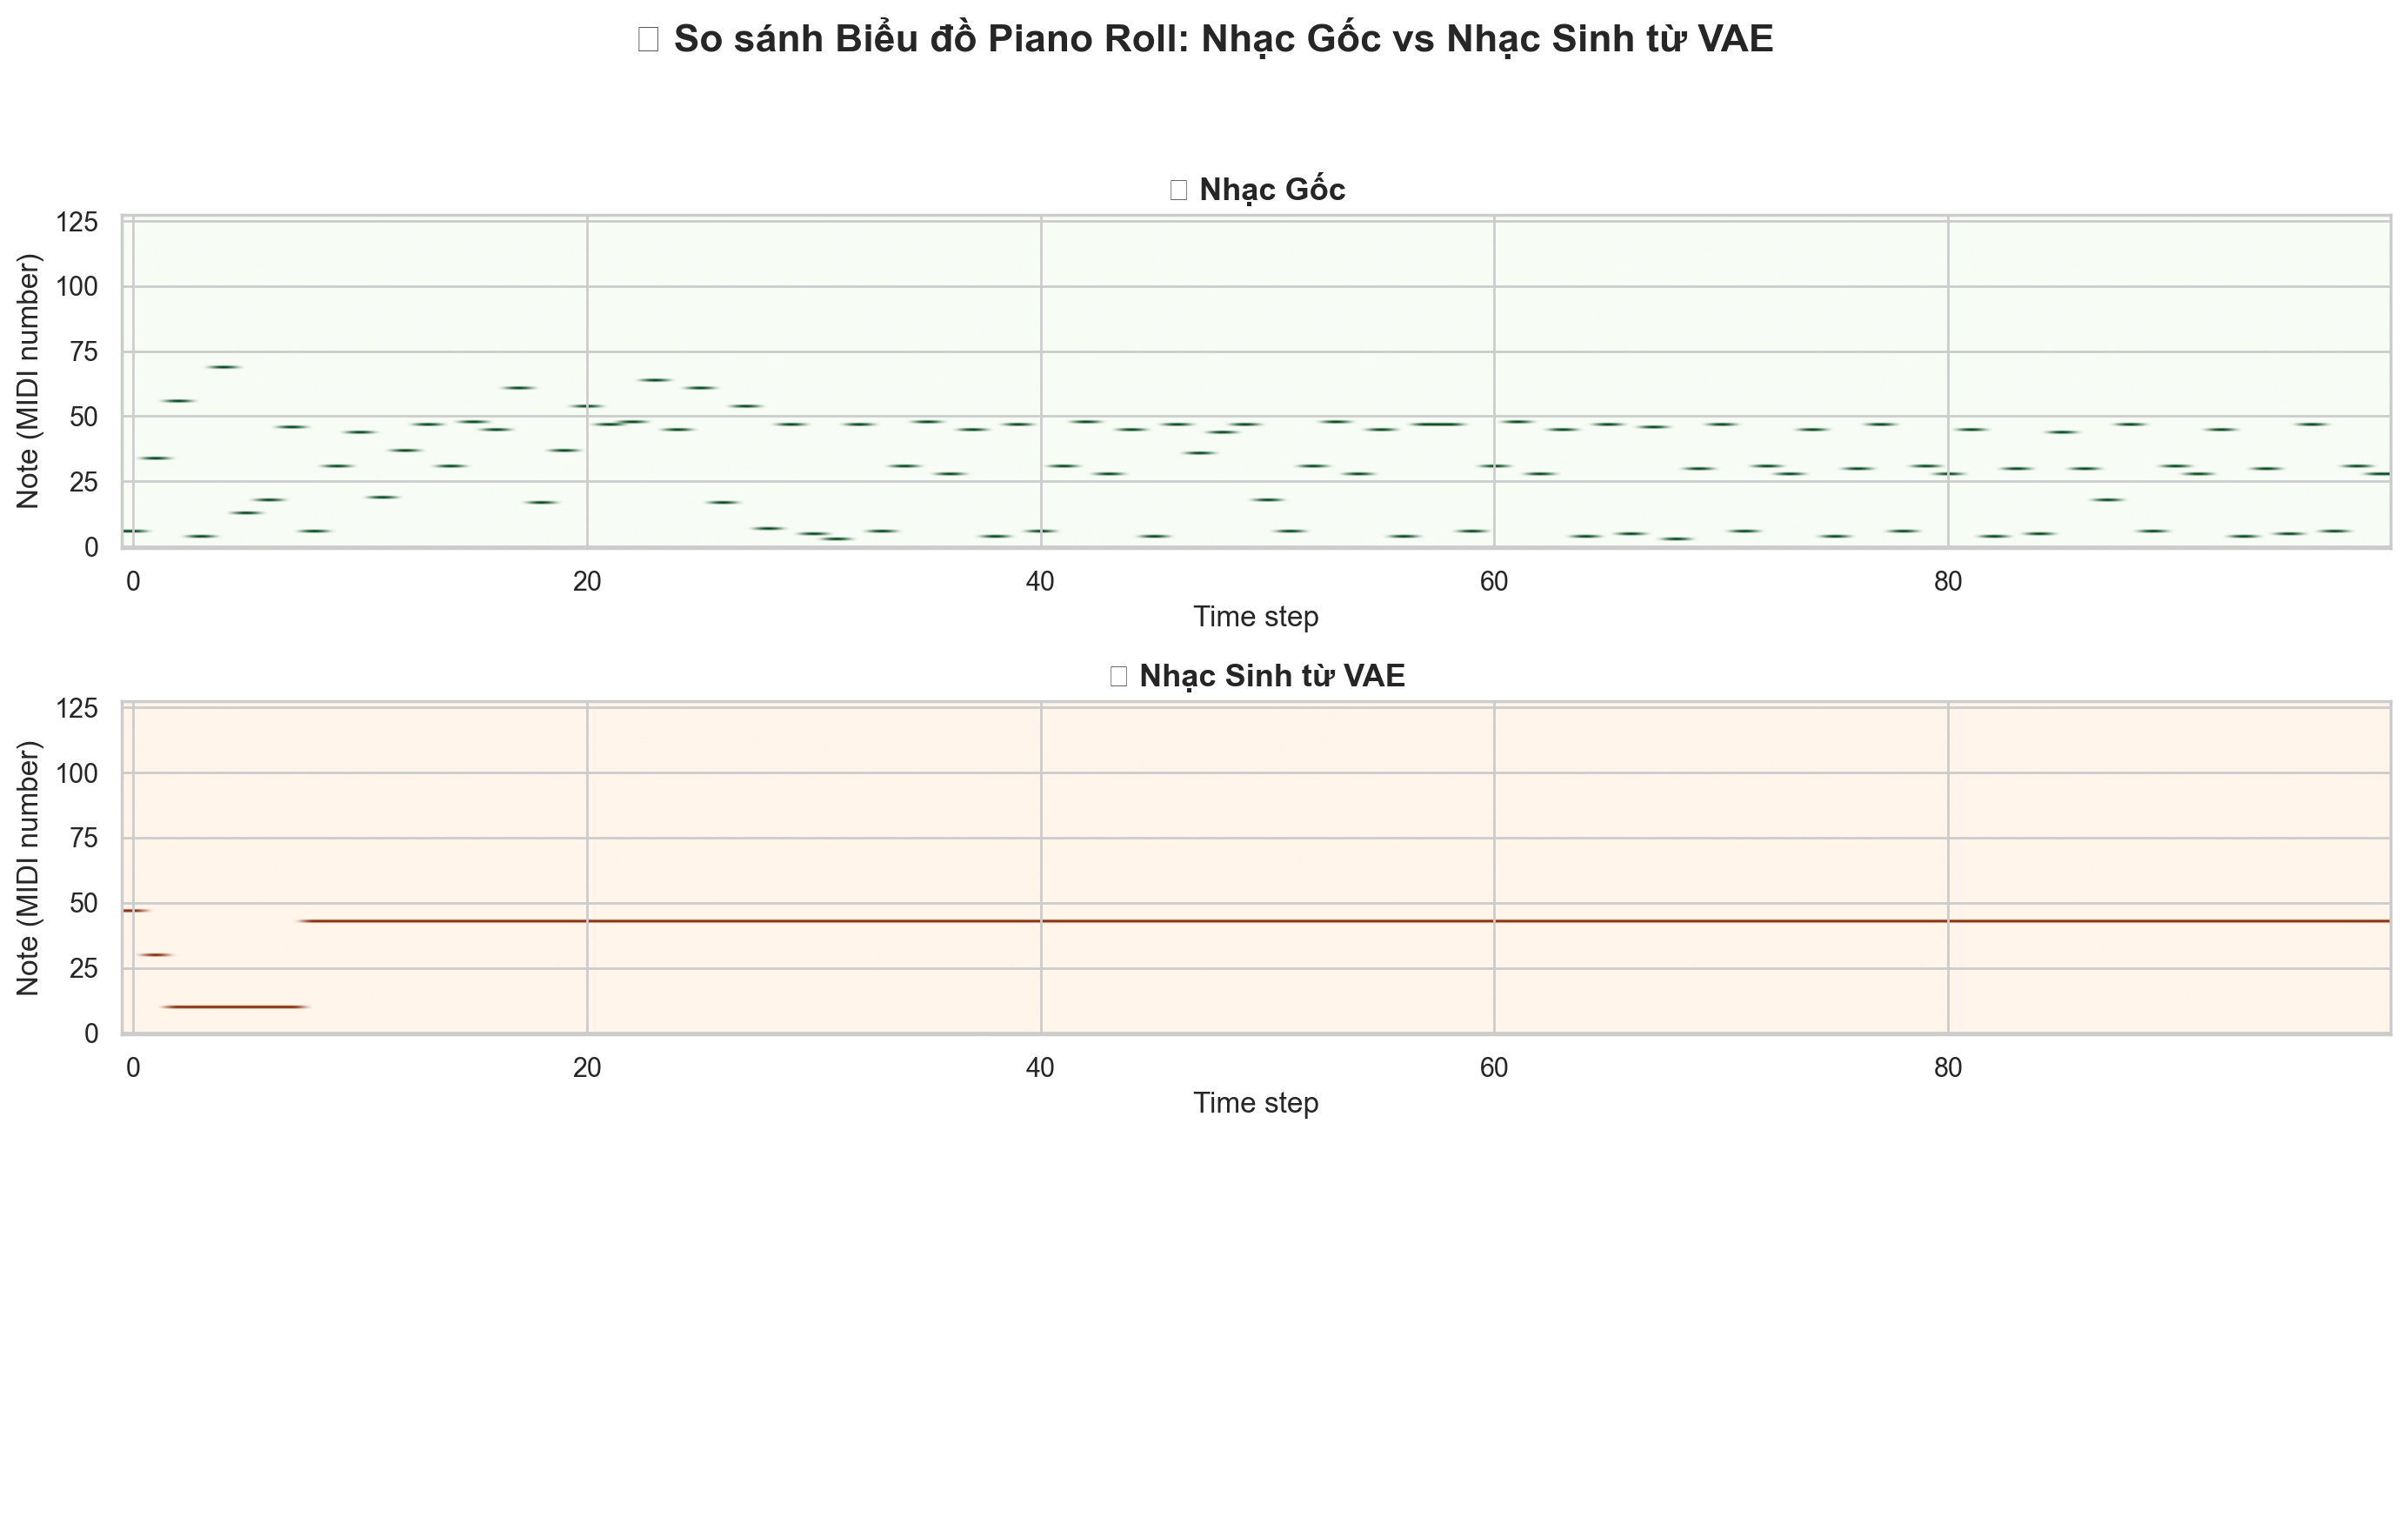

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def plot_piano_roll(note_sequence, title, ax, cmap="Blues", num_notes=128):
    """
    V·∫Ω piano roll t·ª´ chu·ªói n·ªët (d·∫°ng ch·ªâ s·ªë n·ªët).
    """
    seq_length = len(note_sequence)
    piano_roll = np.zeros((num_notes, seq_length))
    for t, note in enumerate(note_sequence):
        if 0 < note < num_notes:
            piano_roll[note, t] = 1
    ax.imshow(piano_roll, aspect='auto', origin='lower', cmap=cmap)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_ylabel("Note (MIDI number)")
    ax.set_xlabel("Time step")

# Gi·∫£ s·ª≠ b·∫°n ƒë√£ c√≥ d·ªØ li·ªáu:
# - `X_test` l√† t·∫≠p ki·ªÉm tra ƒë·∫ßu v√†o c·ªßa m√¥ h√¨nh
# - `decoder` l√† decoder t·ª´ VAE
# - `latent_dim` l√† s·ªë chi·ªÅu kh√¥ng gian ti·ªÅm ·∫©n

# V·∫Ω bi·ªÉu ƒë·ªì
fig, axs = plt.subplots(3, 1, figsize=(14, 9))

# Nh·∫°c g·ªëc
original_seq = X_test[0].squeeze()
plot_piano_roll(original_seq, "üéº Nh·∫°c G·ªëc", axs[0], cmap="Greens")

# Nh·∫°c sinh t·ª´ VAE
z_sample = tf.random.normal(shape=(1, latent_dim))
vae_probs = decoder.predict(z_sample)
vae_seq = np.argmax(vae_probs, axis=-1)[0]
plot_piano_roll(vae_seq, "üéπ Nh·∫°c Sinh t·ª´ VAE", axs[1], cmap="Oranges")

# (N·∫øu b·∫°n c√≥ th·ªÉ th√™m m·ªôt m√¥ h√¨nh kh√°c, v√≠ d·ª• LSTM hay Transformer th√¨ c√≥ th·ªÉ v·∫Ω ·ªü d√≤ng th·ª© 3)
axs[2].axis("off")  # ·∫®n bi·ªÉu ƒë·ªì th·ª© 3 n·∫øu ch∆∞a d√πng

# Ti√™u ƒë·ªÅ chung
fig.suptitle("üîç So s√°nh Bi·ªÉu ƒë·ªì Piano Roll: Nh·∫°c G·ªëc vs Nh·∫°c Sinh t·ª´ VAE", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("vae_piano_roll_comparison.png", dpi=300)
plt.show()



Transformer

In [ ]:
# Transformer Block 
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
class TransformerMusicModel(Model):
    def __init__(self, num_notes, embed_dim=128, num_heads=4, ff_dim=512, num_layers=4, seq_length=50):
        super(TransformerMusicModel, self).__init__()
        self.embedding = Embedding(input_dim=num_notes, output_dim=embed_dim)
        self.pos_encoding = self.positional_encoding(seq_length, embed_dim)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)]
        self.dropout = Dropout(0.1)
        self.dense = Dense(num_notes, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        x += self.pos_encoding
        x = self.dropout(x, training=training)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
        x = tf.reduce_mean(x, axis=1)
        return self.dense(x)

    def positional_encoding(self, seq_length, embed_dim):
        pos = np.arange(seq_length)[:, np.newaxis]
        i = np.arange(embed_dim)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        pos_encoding = pos * angle_rates
        pos_encoding[:, 0::2] = np.sin(pos_encoding[:, 0::2])
        pos_encoding[:, 1::2] = np.cos(pos_encoding[:, 1::2])
        return tf.cast(pos_encoding, dtype=tf.float32)

pickle_path = "D:/CƒêE/test/midi_data_music21.pkl"
with open(pickle_path, "rb") as f:
    data = pickle.load(f)

if isinstance(data, dict):
    midi_data = data["data"]
    note_to_int = data["note_to_int"]
else:
    midi_data = data
    all_notes = sorted(set(note["pitch"] for song in midi_data for note in song))
    note_to_int = {note: i + 1 for i, note in enumerate(all_notes)}

num_notes = len(note_to_int) + 1
seq_length = 50

X, y = [], []
for song in midi_data:
    notes = np.array([note_to_int.get(note["pitch"], 0) for note in song])
    for i in range(len(notes) - seq_length):
        X.append(notes[i:i + seq_length])
        y.append(notes[i + seq_length])
X = np.array(X)
y = np.array(y)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = TransformerMusicModel(num_notes, seq_length=seq_length)
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(0.001), metrics=["accuracy"])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16
)

#L∆∞u m√¥ h√¨nh
os.makedirs("D:/CƒêE/test", exist_ok=True)
model.save("D:/CƒêE/test/generator_transformer.h5")

In [ ]:
# ==== V·∫Ω bi·ªÉu ƒë·ªì Loss v√† Accuracy ====
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Bi·ªÉu ƒë·ªì Loss theo Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Bi·ªÉu ƒë·ªì Accuracy theo Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

# H√ÄM T·∫†O NH·∫†C T·ªêI ƒêA 20-25s
def generate_music(model, start_sequence, note_to_int, int_to_note, output_length=80, filename="generated_music_trans.mid"):
    generated = list(start_sequence)
    
    for _ in range(output_length):
        input_seq = np.array([generated[-seq_length:]])  # L·∫•y chu·ªói g·∫ßn nh·∫•t
        pred_probs = model.predict(input_seq, verbose=0)[0]
        next_note_int = np.random.choice(len(pred_probs), p=pred_probs)  # L·∫•y note ti·∫øp theo theo x√°c su·∫•t
        generated.append(next_note_int)

    generated_notes = [int_to_note.get(i, "C4") for i in generated]
    
    midi_stream = stream.Stream()
    for i, note_name in enumerate(generated_notes):
        if "." in note_name or note_name.isdigit():  # N·∫øu l√† h·ª£p √¢m
            chord_notes = note_name.split(".")
            chord_obj = chord.Chord(chord_notes)
            chord_obj.quarterLength = 0.25  # ƒê·ªô d√†i n·ªët
            midi_stream.append(chord_obj)
        else:  # N·∫øu l√† n·ªët ƒë∆°n
            note_obj = note.Note(note_name)
            note_obj.quarterLength = 0.25  # Gi·ªØ nh·∫°c kho·∫£ng 20-25 gi√¢y
            midi_stream.append(note_obj)

    midi_fp = os.path.join("D:/CƒêE/test", filename)
    midi_stream.write("midi", fp=midi_fp)
    print(f"ƒê√£ l∆∞u nh·∫°c v√†o {midi_fp}")

# Ch·ªçn m·ªôt ƒëo·∫°n nh·∫°c ng·∫´u nhi√™n t·ª´ t·∫≠p d·ªØ li·ªáu ƒë·ªÉ b·∫Øt ƒë·∫ßu sinh nh·∫°c
start_index = np.random.randint(0, len(X))
start_sequence = X[start_index]

# Map ng∆∞·ª£c t·ª´ s·ªë v·ªÅ n·ªët
int_to_note = {i: n for n, i in note_to_int.items()}

# Sinh nh·∫°c v·ªõi ƒë·ªô d√†i t·ªëi ƒëa 20-25s
generate_music(model, start_sequence, note_to_int, int_to_note, output_length=80, filename="generated_trans.mid")


In [ ]:
# H√†m chuy·ªÉn MIDI sang piano roll
def midi_to_piano_roll(midi_path, duration_limit=25.0, fs=4):
    midi = music21.converter.parse(midi_path)
    piano_roll = np.zeros((128, int(duration_limit * fs)))  # 128 pitch, fs = frames/second

    time = 0
    for el in midi.flat.notes:
        if isinstance(el, music21.note.Note):
            pitch = el.pitch.midi
            duration = float(el.quarterLength)
            start = int(time * fs)
            end = int((time + duration) * fs)
            piano_roll[pitch, start:end] = 1
            time += duration
        if time >= duration_limit:
            break

    return piano_roll

# ƒê∆∞·ªùng d·∫´n c√°c file MIDI
midi_paths = {
    "G·ªëc": "D:/CƒêE/data/C√°t b·ª•i.mid",
    "CNN": "D:/CƒêE/test_1/generated_trans.mid",
}


fig, axes = plt.subplots(1, len(midi_paths), figsize=(10, 5), sharey=True, facecolor='white')

fs = 4
frame_ticks = np.arange(0, 25*fs+1, 4)
sec_labels = [str(int(x/fs)) + "s" for x in frame_ticks]

for i, (title, path) in enumerate(midi_paths.items()):
    if not os.path.exists(path):
        print(f"File kh√¥ng t·ªìn t·∫°i: {path}")
        continue

    roll = midi_to_piano_roll(path, duration_limit=25, fs=fs)

    ax = axes[i]
    im = ax.imshow(roll, aspect='auto', origin='lower',
                   cmap='YlGnBu',  # m√†u nh·∫π h∆°n viridis
                   interpolation='nearest', alpha=1)  # alpha gi·∫£m cho d·ªãu m·∫Øt
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Th·ªùi gian", fontsize=12)
    ax.set_xticks(frame_ticks)
    ax.set_xticklabels(sec_labels, rotation=45)
    ax.set_yticks([36, 48, 60, 72, 84, 96])
    ax.set_yticklabels(['C2', 'C3', 'C4', 'C5', 'C6', 'C7'])
    ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.3, alpha=0.5)
    ax.set_facecolor('#fcfcfc')
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgray')

fig.suptitle("So s√°nh bi·ªÉu ƒë·ªì Piano Roll", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Mo hinh CNNs

In [ ]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split

# Load d·ªØ li·ªáu
with open("D:/CƒêE/test/midi_data_music21.pkl", "rb") as f:
    loaded_data = pickle.load(f)

# X·ª≠ l√Ω note -> int
if isinstance(loaded_data, dict):
    midi_data = loaded_data["data"]
    note_to_int = loaded_data["note_to_int"]
else:
    midi_data = loaded_data
    all_notes = sorted(set(note["pitch"] for song in midi_data for note in song))
    note_to_int = {note: i + 1 for i, note in enumerate(all_notes)}

num_notes = len(note_to_int) + 1
seq_length = 100
X, y = [], []

for song in midi_data:
    notes = [note_to_int.get(note["pitch"], 0) for note in song]
    for i in range(len(notes) - seq_length):
        X.append(notes[i:i + seq_length])
        y.append(notes[i + seq_length])

X, y = np.array(X), np.array(y)

# Chia d·ªØ li·ªáu
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = Sequential([
    Embedding(input_dim=num_notes, output_dim=128, input_length=seq_length),
    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_notes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])
history_cnn= model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32)
# L∆∞u m√¥ h√¨nh
model.save("D:/CƒêE/test/generator_cnn.h5")

In [ ]:
# Bi·ªÉu ƒë·ªì Loss v√† Accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Loss qua c√°c epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title('Accuracy qua c√°c epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
# √Ånh x·∫° l·∫°i note
all_notes = sorted(note_to_int.keys(), key=lambda x: note_to_int[x])
int_to_note = {i: n for n, i in note_to_int.items()}

BPM = 120
SECONDS_PER_BEAT = 60 / BPM

def generate_music(model, seed_sequence, min_duration=20.0, max_duration=25.0):
    output = list(seed_sequence)
    total_duration = 0

    while total_duration < min_duration:
        input_seq = np.array(output[-seq_length:]).reshape(1, seq_length)
        predicted_note = np.argmax(model.predict(input_seq, verbose=0))

        if predicted_note not in int_to_note:
            continue

        note_duration = np.random.choice([0.5, 1.0, 1.5, 2.0])
        note_time = note_duration * SECONDS_PER_BEAT

        if total_duration + note_time > max_duration:
            break

        output.append(predicted_note)
        total_duration += note_time

    return output

# Load m√¥ h√¨nh
model = load_model("D:/CƒêE/test/generator_cnn.h5")

# Sinh nh·∫°c
seed = [note_to_int[note["pitch"]] for note in midi_data[0][:seq_length]]
generated = generate_music(model, seed)

# Chuy·ªÉn th√†nh MIDI
stream = music21.stream.Stream()
total_duration = 0
for note_id in generated:
    if note_id not in int_to_note: continue
    note_name = int_to_note[note_id]
    duration = np.random.choice([0.5, 1.0, 1.5, 2.0])
    duration_in_seconds = duration * SECONDS_PER_BEAT
    total_duration += duration_in_seconds
    if total_duration > 25:
        break
    note_obj = music21.note.Note(note_name)
    note_obj.quarterLength = duration
    stream.append(note_obj)

stream.write("midi", fp="D:/CƒêE/test/generated_music_cnn.mid")
print("Nh·∫°c ƒë√£ ƒë∆∞·ª£c sinh v√† l∆∞u.")


In [ ]:
import matplotlib.pyplot as plt

def plot_piano_roll(generated_notes, int_to_note):
    note_names = [int_to_note.get(n, 'Rest') for n in generated_notes]
    pitch_vals = [music21.note.Note(n).pitch.midi if n != 'Rest' else 0 for n in note_names]
    
    plt.figure(figsize=(12, 6))
    plt.plot(pitch_vals, marker='o', linestyle='-')
    plt.title("Piano Roll - Nh·∫°c sinh ra")
    plt.xlabel("Th·ª© t·ª± n·ªët")
    plt.ylabel("Pitch (MIDI number)")
    plt.grid(True)
    plt.show()

plot_piano_roll(generated, int_to_note)


In [ ]:
# H√†m chuy·ªÉn MIDI sang piano roll
def midi_to_piano_roll(midi_path, duration_limit=25.0, fs=4):
    midi = music21.converter.parse(midi_path)
    piano_roll = np.zeros((128, int(duration_limit * fs)))  # 128 pitch, fs = frames/second

    time = 0
    for el in midi.flat.notes:
        if isinstance(el, music21.note.Note):
            pitch = el.pitch.midi
            duration = float(el.quarterLength)
            start = int(time * fs)
            end = int((time + duration) * fs)
            piano_roll[pitch, start:end] = 1
            time += duration
        if time >= duration_limit:
            break

    return piano_roll

# ƒê∆∞·ªùng d·∫´n c√°c file MIDI
midi_paths = {
    "G·ªëc": "D:\CƒêE\data\Di·ªÖm x∆∞a.mid",
    "CNN": "D:/CƒêE/test_1/generated_music_cnn.mid",
}


fig, axes = plt.subplots(1, len(midi_paths), figsize=(10, 5), sharey=True, facecolor='white')

fs = 4
frame_ticks = np.arange(0, 25*fs+1, 4)
sec_labels = [str(int(x/fs)) + "s" for x in frame_ticks]

for i, (title, path) in enumerate(midi_paths.items()):
    if not os.path.exists(path):
        print(f"File kh√¥ng t·ªìn t·∫°i: {path}")
        continue

    roll = midi_to_piano_roll(path, duration_limit=25, fs=fs)

    ax = axes[i]
    im = ax.imshow(roll, aspect='auto', origin='lower',
                   cmap='YlGnBu',  # m√†u nh·∫π h∆°n viridis
                   interpolation='nearest', alpha=1)  # alpha gi·∫£m cho d·ªãu m·∫Øt
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Th·ªùi gian", fontsize=12)
    ax.set_xticks(frame_ticks)
    ax.set_xticklabels(sec_labels, rotation=45)
    ax.set_yticks([36, 48, 60, 72, 84, 96])
    ax.set_yticklabels(['C2', 'C3', 'C4', 'C5', 'C6', 'C7'])
    ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.3, alpha=0.5)
    ax.set_facecolor('#fcfcfc')
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgray')

fig.suptitle("So s√°nh bi·ªÉu ƒë·ªì Piano Roll", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# ====== 1. ƒê·ªçc d·ªØ li·ªáu g·ªëc t·ª´ CSV ======
csv_path = "D:/CƒêE/test/midi_segmented.csv"
df_midi = pd.read_csv(csv_path)

# H√†m chuy·ªÉn ƒë·ªïi gi√° tr·ªã duration sang float
def convert_duration(value):
    try:
        return float(value)  # N·∫øu ƒë√£ l√† s·ªë, gi·ªØ nguy√™n
    except ValueError:
        try:
            return float(fractions.Fraction(value))  # Chuy·ªÉn ph√¢n s·ªë th√†nh float
        except ValueError:
            return None  # N·∫øu kh√¥ng chuy·ªÉn ƒë·ªïi ƒë∆∞·ª£c, tr·∫£ v·ªÅ None

# Chuy·ªÉn ƒë·ªïi c·ªôt "duration"
df_midi["duration"] = df_midi["duration"].dropna().apply(convert_duration)
df_midi = df_midi.dropna(subset=["duration"])  # Lo·∫°i b·ªè c√°c gi√° tr·ªã l·ªói
original_durations = df_midi["duration"].astype(float).tolist()  # Chuy·ªÉn th√†nh danh s√°ch s·ªë th·ª±c

# ====== 2. Tr√≠ch xu·∫•t ƒë·ªô d√†i n·ªët nh·∫°c t·ª´ file MIDI ======
def extract_note_durations(midi_path):
    """Tr√≠ch xu·∫•t danh s√°ch ƒë·ªô d√†i c√°c n·ªët nh·∫°c t·ª´ file MIDI"""
    mid = MidiFile(midi_path)
    note_durations = []
    note_start_times = {}

    current_time = 0
    for msg in mid:
        current_time += msg.time
        if msg.type == 'note_on' and msg.velocity > 0:
            note_start_times[msg.note] = current_time
        elif msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0):
            if msg.note in note_start_times:
                duration = current_time - note_start_times.pop(msg.note, current_time)
                note_durations.append(duration)
    
    return note_durations

# Danh s√°ch file MIDI c·ªßa c√°c m√¥ h√¨nh
midi_files = {
    "Transformer": "D:/CƒêE/test/generated_trans.mid",
    "VAE": "D:/CƒêE/test/generated_music_vae.mid",
    "LSTM": "D:/CƒêE/test/generated_music_lstm.mid",
    "CNN": "D:/CƒêE/test/generated_music_cnn.mid"
}

# Tr√≠ch xu·∫•t ƒë·ªô d√†i n·ªët nh·∫°c t·ª´ c√°c m√¥ h√¨nh
generated_durations = {model: extract_note_durations(path) for model, path in midi_files.items()}

# ====== 3. V·∫Ω bi·ªÉu ƒë·ªì so s√°nh ph√¢n b·ªë ƒë·ªô d√†i n·ªët nh·∫°c ======
plt.figure(figsize=(12, 6))

# V·∫Ω histogram v·ªõi KDE
sns.histplot(original_durations, bins=30, kde=True, color="black", label="D·ªØ li·ªáu g·ªëc", alpha=0.5, linewidth=2)

colors = ["red", "blue", "green", "purple"]
for (model, durations), color in zip(generated_durations.items(), colors):
    sns.histplot(durations, bins=30, kde=True, label=model, color=color, alpha=0.4, linewidth=2)

# C·∫•u h√¨nh tr·ª•c x v√† y
plt.xlim(0, 2)  # Gi·ªõi h·∫°n tr·ª•c x (c√≥ th·ªÉ thay ƒë·ªïi t√πy d·ªØ li·ªáu)
plt.ylim(0, None)  # ƒê·ªÉ y t·ª± ƒë·ªông ƒëi·ªÅu ch·ªânh theo d·ªØ li·ªáu

# C·∫•u h√¨nh nh√£n v√† ti√™u ƒë·ªÅ
plt.xlabel("ƒê·ªô d√†i n·ªët nh·∫°c (MIDI ticks)", fontsize=12)
plt.ylabel("M·∫≠t ƒë·ªô", fontsize=12)
plt.title("So s√°nh ph√¢n b·ªë ƒë·ªô d√†i n·ªët nh·∫°c", fontsize=14, fontweight="bold")

# Hi·ªÉn th·ªã l∆∞·ªõi v√† ch√∫ th√≠ch
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="M√¥ h√¨nh", fontsize=10)

plt.show()

